In [87]:
import pandas as pd
import random
from time import sleep
import warnings
import numpy as np
import nltk
import os
from sklearn import datasets
import pickle
from nltk.tokenize import word_tokenize
from sklearn.decomposition import NMF, TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.neighbors import NearestNeighbors
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc, fbeta_score
from sklearn.model_selection import learning_curve, KFold, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import normalize

import matplotlib.style as style
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings('ignore')

In [2]:
with open('data/cleaned_df.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [3]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [4]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [5]:
df.head()

,song_owner,song_title,song_element,verse,artist
0,Childish Gambino,This Is America,[Bridge: Childish Gambino & Young Thug],"We just wanna party, Party just for you, We ju...",Childish Gambino
1,Childish Gambino,This Is America,[Chorus: Childish Gambino],"This is America, Don't catch you slippin' now,...",Childish Gambino
2,Childish Gambino,This Is America,"[Verse 1: Childish Gambino, Blocboy JB, Slim J...","This is America (skrrt, skrrt, woo), Don't cat...",Childish Gambino
3,Childish Gambino,This Is America,[Refrain: Choir & Childish Gambino],"Ooh-ooh-ooh-ooh-ooh, tell somebody, You go tel...",Childish Gambino
4,Childish Gambino,This Is America,"[Chorus: Childish Gambino, Slim Jxmmi & Young ...","This is America (woo, ayy), Don't catch you sl...",Childish Gambino


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6304 entries, 0 to 6303
Data columns (total 5 columns):
song_owner      6304 non-null object
song_title      6304 non-null object
song_element    6304 non-null object
verse           6304 non-null object
artist          6304 non-null object
dtypes: object(5)
memory usage: 246.3+ KB


In [7]:
model_df = df.copy()

In [8]:
model_df.artist.value_counts()

Kanye West           1933
Drake                1596
Kendrick Lamar       1483
Childish Gambino      824
Chance the Rapper     468
Name: artist, dtype: int64

In [9]:
from nltk.tokenize import word_tokenize
model_df['verse_words'] = model_df['verse'].apply(lambda x: word_tokenize(x))

In [10]:
model_df.reset_index(drop=True, inplace=True)

In [11]:
stemmer = nltk.stem.porter.PorterStemmer()

model_df['verse_stem'] = model_df["verse_words"].apply(lambda x: [stemmer.stem(y) for y in x])

In [12]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

model_df['verse_lem'] = model_df["verse_words"].apply(lambda x: [wordnet_lemmatizer.lemmatize(y, pos='v') for y in x])

In [13]:
model_df['verse_stem'] = model_df['verse_stem'].apply(', '.join)
model_df['verse_stem'] = model_df['verse_stem'].apply(lambda x: x.replace(", ", " "))

In [14]:
model_df['verse_lem'] = model_df['verse_lem'].apply(', '.join)
model_df['verse_lem'] = model_df['verse_lem'].apply(lambda x: x.replace(", ", " "))

In [15]:
model_df['rapper'] = 0

In [16]:
model_df.head()

,song_owner,song_title,song_element,verse,artist,verse_words,verse_stem,verse_lem,rapper
0,Childish Gambino,This Is America,[Bridge: Childish Gambino & Young Thug],"We just wanna party, Party just for you, We ju...",Childish Gambino,"[We, just, wan, na, party, ,, Party, just, for...","We just wan na parti , parti just for you , We...","We just wan na party , Party just for you , We...",0
1,Childish Gambino,This Is America,[Chorus: Childish Gambino],"This is America, Don't catch you slippin' now,...",Childish Gambino,"[This, is, America, ,, Do, n't, catch, you, sl...","thi is america , Do n't catch you slippin ' no...","This be America , Do n't catch you slippin ' n...",0
2,Childish Gambino,This Is America,"[Verse 1: Childish Gambino, Blocboy JB, Slim J...","This is America (skrrt, skrrt, woo), Don't cat...",Childish Gambino,"[This, is, America, (, skrrt, ,, skrrt, ,, woo...","thi is america ( skrrt , skrrt , woo ) , Do n'...","This be America ( skrrt , skrrt , woo ) , Do n...",0
3,Childish Gambino,This Is America,[Refrain: Choir & Childish Gambino],"Ooh-ooh-ooh-ooh-ooh, tell somebody, You go tel...",Childish Gambino,"[Ooh-ooh-ooh-ooh-ooh, ,, tell, somebody, ,, Yo...","ooh-ooh-ooh-ooh-ooh , tell somebodi , you go t...","Ooh-ooh-ooh-ooh-ooh , tell somebody , You go t...",0
4,Childish Gambino,This Is America,"[Chorus: Childish Gambino, Slim Jxmmi & Young ...","This is America (woo, ayy), Don't catch you sl...",Childish Gambino,"[This, is, America, (, woo, ,, ayy, ), ,, Do, ...","thi is america ( woo , ayi ) , Do n't catch yo...","This be America ( woo , ayy ) , Do n't catch y...",0


In [17]:
model_df.loc[model_df["artist"] == 'Childish Gambino', "rapper"] = 1
model_df.loc[model_df["artist"] == 'Chance the Rapper', "rapper"] = 2
model_df.loc[model_df["artist"] == 'Drake', "rapper"] = 3
model_df.loc[model_df["artist"] == 'Kendrick Lamar', "rapper"] = 4
model_df.loc[model_df["artist"] == 'Kanye West', "rapper"] = 5

In [18]:
model_df.head()

,song_owner,song_title,song_element,verse,artist,verse_words,verse_stem,verse_lem,rapper
0,Childish Gambino,This Is America,[Bridge: Childish Gambino & Young Thug],"We just wanna party, Party just for you, We ju...",Childish Gambino,"[We, just, wan, na, party, ,, Party, just, for...","We just wan na parti , parti just for you , We...","We just wan na party , Party just for you , We...",1
1,Childish Gambino,This Is America,[Chorus: Childish Gambino],"This is America, Don't catch you slippin' now,...",Childish Gambino,"[This, is, America, ,, Do, n't, catch, you, sl...","thi is america , Do n't catch you slippin ' no...","This be America , Do n't catch you slippin ' n...",1
2,Childish Gambino,This Is America,"[Verse 1: Childish Gambino, Blocboy JB, Slim J...","This is America (skrrt, skrrt, woo), Don't cat...",Childish Gambino,"[This, is, America, (, skrrt, ,, skrrt, ,, woo...","thi is america ( skrrt , skrrt , woo ) , Do n'...","This be America ( skrrt , skrrt , woo ) , Do n...",1
3,Childish Gambino,This Is America,[Refrain: Choir & Childish Gambino],"Ooh-ooh-ooh-ooh-ooh, tell somebody, You go tel...",Childish Gambino,"[Ooh-ooh-ooh-ooh-ooh, ,, tell, somebody, ,, Yo...","ooh-ooh-ooh-ooh-ooh , tell somebodi , you go t...","Ooh-ooh-ooh-ooh-ooh , tell somebody , You go t...",1
4,Childish Gambino,This Is America,"[Chorus: Childish Gambino, Slim Jxmmi & Young ...","This is America (woo, ayy), Don't catch you sl...",Childish Gambino,"[This, is, America, (, woo, ,, ayy, ), ,, Do, ...","thi is america ( woo , ayi ) , Do n't catch yo...","This be America ( woo , ayy ) , Do n't catch y...",1


In [19]:
artist_name = ['Childish Gambino', 'Chance the Rapper', 'Drake', 'Kendrick Lamar', 'Kanye West']

In [20]:
verses = list(model_df.verse.values)

In [21]:
print(verses[:10])

["We just wanna party, Party just for you, We just want the money, Money just for you (yeah), I know you wanna party, Party just for free, Girl, you got me dancin' (girl, you got me dancin'), Dance and shake the frame (yeah), We just wanna party (yeah), Party just for you (yeah), We just want the money (yeah), Money just for you (you), I know you wanna party (yeah), Party just for free (yeah), Girl, you got me dancin' (girl, you got me dancin', yeah), Dance and shake the frame (ooh)", "This is America, Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now, This is America (woo), Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now", "This is America (skrrt, skrrt, woo), Don't catch you slippin' now (ayy), Look how I'm livin' now, Police be trippin' now (woo), Yeah, this is America (woo, ayy), Guns in my area (word, my area), I got the strap (ayy, ayy), I gotta carry 'em, Yeah, yeah, I'ma go into this (ugh), Yeah, yeah, 

In [24]:
model_df.index

RangeIndex(start=0, stop=6304, step=1)

In [27]:
def get_recommendations(first_verse, model, vectorizer, training_vectors):
    '''
    first_article: (string) An article that we want to use to find similar articles
    model: (a fit dimensionality reducer) Projects vectorized words onto a subspace 
           (uses NMF or SVD/LSA typically)
    training_vectors: (numpy array shape) a (num_docs in training) x (NMF/SVD/LSA) dimensional array.
                      Used to train NearestNeighbors model
    '''
    new_vec = model.transform(
        vectorizer.transform([first_verse]))
    nn = NearestNeighbors(n_neighbors=11, metric='cosine', algorithm='brute')
    nn.fit(training_vectors)
    results = nn.kneighbors(new_vec)
    return results[1][0][1:]

In [28]:
def print_recommendations(first_verse,recommend_list):
    artist = model_df.artist.iloc[first_verse]
    verse = model_df.verse.iloc[first_verse]
    print(artist)
    print(verse)
    print('\n------\n')
    for resp in recommend_list:
        print('\n --- Result --- \n')
        print(model_df.artist.iloc[resp])
        print(model_df.verse.iloc[resp])

In [29]:
def recommendations_correct(first_verse,recommend_list):
    artist_total_correct = 0
    artist_total_wrong = 0
    artist = model_df.artist.iloc[first_verse]
    verse = model_df.verse.iloc[first_verse]
    for resp in recommend_list:
        if model_df.artist.iloc[resp] == artist:
            artist_total_correct += 1
        else:
            artist_total_wrong += 1
    percent_correct = (artist_total_correct / (artist_total_correct + artist_total_wrong))*100
    return percent_correct
    # return (f' Percent correct: {percent_correct}')

In [130]:
## PICKLE LDA ON CV_DATA SO YOU DON'T HAVE TO REFIT IT EACH TIME

with open('data/df_all_rappers.pkl', 'wb') as picklefile:
    pickle.dump(model_df, picklefile)

In [123]:
model_df.head()

,song_owner,song_title,song_element,verse,artist,verse_words,verse_stem,verse_lem,rapper
0,Childish Gambino,This Is America,[Bridge: Childish Gambino & Young Thug],"We just wanna party, Party just for you, We ju...",Childish Gambino,"[We, just, wan, na, party, ,, Party, just, for...","We just wan na parti , parti just for you , We...","We just wan na party , Party just for you , We...",1
1,Childish Gambino,This Is America,[Chorus: Childish Gambino],"This is America, Don't catch you slippin' now,...",Childish Gambino,"[This, is, America, ,, Do, n't, catch, you, sl...","thi is america , Do n't catch you slippin ' no...","This be America , Do n't catch you slippin ' n...",1
2,Childish Gambino,This Is America,"[Verse 1: Childish Gambino, Blocboy JB, Slim J...","This is America (skrrt, skrrt, woo), Don't cat...",Childish Gambino,"[This, is, America, (, skrrt, ,, skrrt, ,, woo...","thi is america ( skrrt , skrrt , woo ) , Do n'...","This be America ( skrrt , skrrt , woo ) , Do n...",1
3,Childish Gambino,This Is America,[Refrain: Choir & Childish Gambino],"Ooh-ooh-ooh-ooh-ooh, tell somebody, You go tel...",Childish Gambino,"[Ooh-ooh-ooh-ooh-ooh, ,, tell, somebody, ,, Yo...","ooh-ooh-ooh-ooh-ooh , tell somebodi , you go t...","Ooh-ooh-ooh-ooh-ooh , tell somebody , You go t...",1
4,Childish Gambino,This Is America,"[Chorus: Childish Gambino, Slim Jxmmi & Young ...","This is America (woo, ayy), Don't catch you sl...",Childish Gambino,"[This, is, America, (, woo, ,, ayy, ), ,, Do, ...","thi is america ( woo , ayi ) , Do n't catch yo...","This be America ( woo , ayy ) , Do n't catch y...",1


In [30]:
print(list(model_df.verse.values)[0:10])

["We just wanna party, Party just for you, We just want the money, Money just for you (yeah), I know you wanna party, Party just for free, Girl, you got me dancin' (girl, you got me dancin'), Dance and shake the frame (yeah), We just wanna party (yeah), Party just for you (yeah), We just want the money (yeah), Money just for you (you), I know you wanna party (yeah), Party just for free (yeah), Girl, you got me dancin' (girl, you got me dancin', yeah), Dance and shake the frame (ooh)", "This is America, Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now, This is America (woo), Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now", "This is America (skrrt, skrrt, woo), Don't catch you slippin' now (ayy), Look how I'm livin' now, Police be trippin' now (woo), Yeah, this is America (woo, ayy), Guns in my area (word, my area), I got the strap (ayy, ayy), I gotta carry 'em, Yeah, yeah, I'ma go into this (ugh), Yeah, yeah, 

In [31]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(["yeah", "like", "uh", "huh", "aw", "oh", "la", "ayy", "okay",
                                               "na", "hey", "nigga", "niggas", "don", "wanna", "shit", "fuck",
                                               "fuckin", "fucking", "want", "know", "ha", "just", "ay", "nah",
                                               "em", "bla", "woo", "wu", "ya", "wala", "woop", "wrarrr", "ooh",
                                               "ba", "duh", "du"])

vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=my_stop_words)

count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words=my_stop_words, 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words=my_stop_words, 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)

cv_data = count_vectorizer.fit_transform(list(model_df.verse_lem.values))
tfidf_data = tfidf_vectorizer.fit_transform(list(model_df.verse_lem.values))

In [32]:
print(cv_data.shape[1])
print(cv_data)

141551
  (0, 45262)	1
  (0, 108665)	2
  (0, 29518)	2
  (0, 29555)	2
  (0, 29557)	2
  (0, 48021)	4
  (0, 45409)	2
  (0, 88954)	2
  (0, 81480)	2
  (0, 81334)	2
  (0, 88974)	2
  (0, 88980)	4
  (0, 134447)	4
  (0, 45245)	2
  (0, 108644)	2
  (0, 29448)	2
  (0, 29550)	4
  (0, 47932)	4
  (0, 45375)	2
  (0, 81127)	4
  (0, 88925)	8
  (0, 134201)	4
  (1, 136795)	1
  (1, 72449)	2
  (1, 111940)	2
  :	:
  (6302, 64762)	1
  (6302, 132042)	1
  (6302, 56108)	1
  (6302, 19040)	2
  (6302, 70997)	1
  (6302, 39467)	1
  (6302, 122463)	1
  (6302, 128493)	1
  (6303, 26369)	1
  (6303, 26340)	1
  (6303, 70966)	2
  (6303, 82554)	2
  (6303, 70953)	2
  (6303, 72792)	2
  (6303, 82530)	2
  (6303, 104252)	2
  (6303, 110941)	1
  (6303, 82506)	2
  (6303, 38004)	1
  (6303, 82543)	2
  (6303, 110911)	1
  (6303, 26284)	2
  (6303, 104234)	2
  (6303, 72761)	2
  (6303, 70901)	4


In [33]:
# lsa_tfidf DIMENSIONALITY REDUCTION ON TFIDF
# Make the other two

n_comp = 60
lsa_tfidf = TruncatedSVD(n_components=n_comp)

lsa_tfidf_data = lsa_tfidf.fit_transform(tfidf_data)
rapper = model_df.rapper

var = lsa_tfidf.explained_variance_ratio_

var1 = np.cumsum(np.round(lsa_tfidf.explained_variance_ratio_, decimals=4)*100)

display_topics(lsa_tfidf,tfidf_vectorizer.get_feature_names(),15)


Topic  0
say, love, make, tell, man, right, ai, time, feel, let, need, cause, wan, ca, come

Topic  1
love, love love, wan love, love wan, love baby, wan, baby love, love better, people love, better heart, better love, wan wan, love way, better, heart better

Topic  2
need need, need, far, god, far far, right, god dream, need far, far need, need right, feel far, hold, need hold, hold corner, baby need

Topic  3
say, day, say say, pray, south, need need, day day, say day, day dance, south south, long, need, dance, swish, way

Topic  4
drink, day, fade drink, faded, drink head, drink sit, drink faded, drink fade, pass drink, head shoot, drink pass, drink wake, faded drink, drink stand, wake drink

Topic  5
day, good, alright, feel, long, time, south, gon alright, better, good good, gon, south south, make, high, way

Topic  6
wan, wan wan, drink, day, feel, wan feel, feel liberate, liberate, alright, girl wan, turn, need need, girl, wan love, love wan

Topic  7
started, started team, sta

hol, amaze, amaze amaze, days, hol hol, ve, mama, best, kanye, hear, forever, best best, understand, west, kanye west

Topic  67
amaze, amaze amaze, new, fall, work, fly, time, leave, talk, feel liberate, liberate, wake, wan feel, mon, work work

Topic  68
forever, best best, best, forever forever, cause, talk, think, night, wake, hol, sky, bless, people, liberate, feel liberate

Topic  69
days, fly, forever, talk, turn, dumb rich, pop style, best best, lifestyle, light, fall, style, rich, dumb, best

Topic  70
hol, hol hol, ai, talk, light, days, po, rapper, hold, time, kanye, talk rapper, jesus, try, girls

Topic  71
hol, new, hol hol, fan, think, hold, long, days, hit fan, fly, wait, miss, hit, love better, ll whack

Topic  72
ve, forever, light, forever forever, sky, black, ready, everybody, kanye, music, make, talk, west, kanye west, boy

Topic  73
really, problem, hear, try, problem problem, ve, run, everybody, kunta, city, fall, black, things, leave, work

Topic  74
best best, m

Text(0,0.5,'Explained Variance (Percent)')

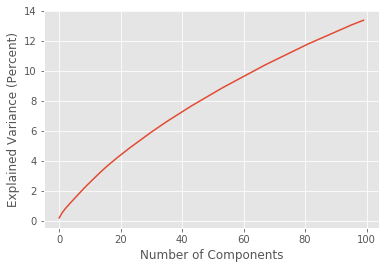

In [34]:
## FIGURE OUT HOW MANY COMPONENTS TO USE

plt.plot(var1)
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance (Percent)")

In [35]:
print(lsa_tfidf_data.shape)
print(lsa_tfidf_data)

(6304, 100)
[[ 0.07199344 -0.0073645  -0.0073969  ... -0.03548786 -0.0264681
  -0.04035315]
 [ 0.02221317 -0.00763107 -0.00343124 ... -0.05936984  0.05720402
  -0.09557992]
 [ 0.04767254 -0.00887762 -0.00708305 ... -0.05333864  0.06899077
  -0.05007709]
 ...
 [ 0.02417166 -0.0031636  -0.00255464 ... -0.03547766  0.00950809
  -0.01079092]
 [ 0.08033254  0.03637494 -0.00602415 ... -0.01524209 -0.00093639
  -0.00095741]
 [ 0.02417166 -0.0031636  -0.00255464 ... -0.03547766  0.00950809
  -0.01079092]]


In [36]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, verbose=1, perplexity=50).fit_transform(lsa_tfidf_data)
X_embedded.shape

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6304 samples in 0.018s...
[t-SNE] Computed neighbors for 6304 samples in 9.138s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6304
[t-SNE] Computed conditional probabilities for sample 2000 / 6304
[t-SNE] Computed conditional probabilities for sample 3000 / 6304
[t-SNE] Computed conditional probabilities for sample 4000 / 6304
[t-SNE] Computed conditional probabilities for sample 5000 / 6304
[t-SNE] Computed conditional probabilities for sample 6000 / 6304
[t-SNE] Computed conditional probabilities for sample 6304 / 6304
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.016121
[t-SNE] Error after 1000 iterations: 2.085195


(6304, 2)

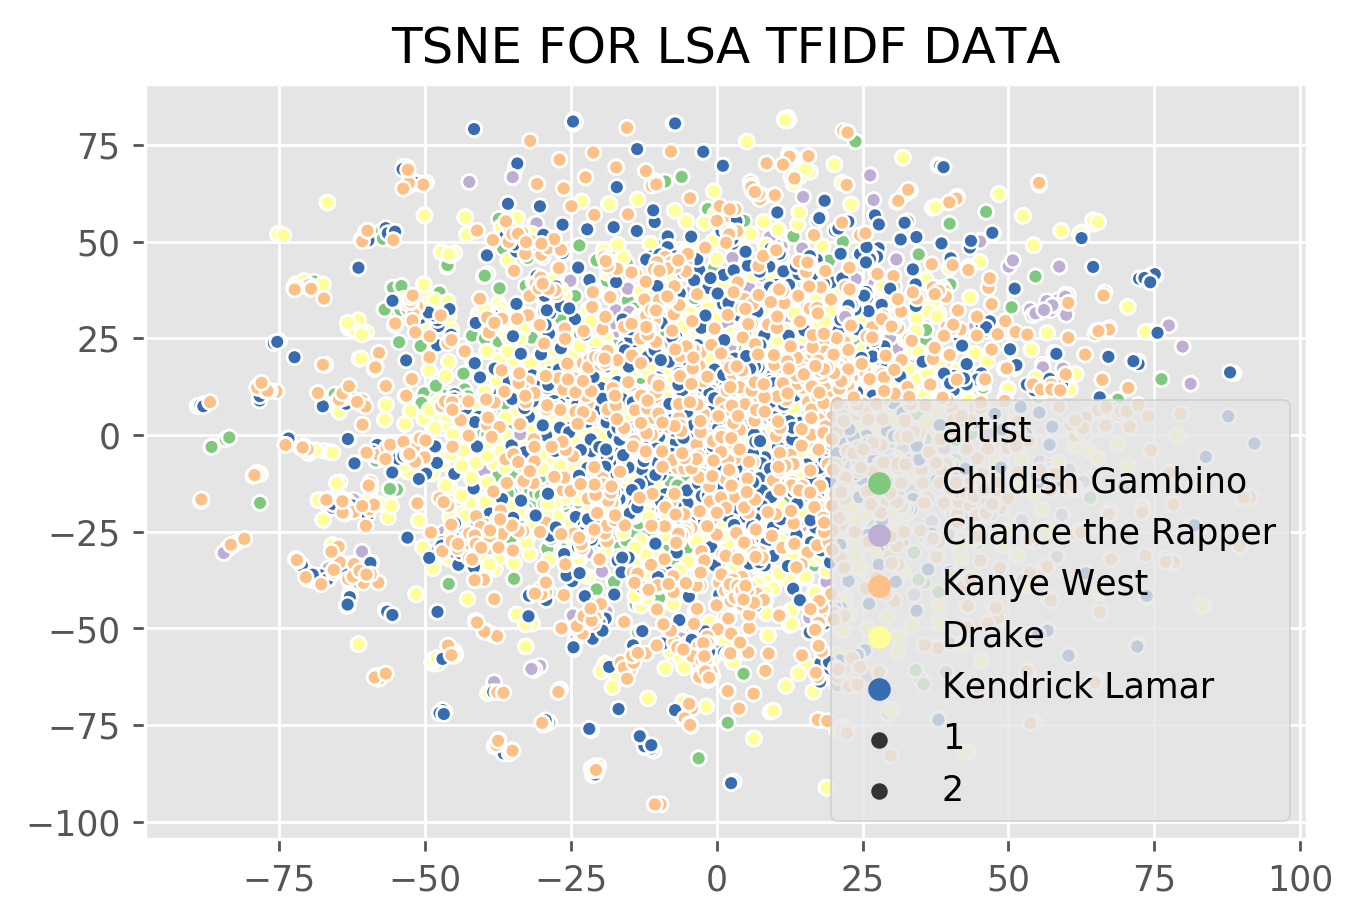

In [37]:
artists = model_df.artist
plt.figure(dpi=250)
plt.title("TSNE FOR LSA TFIDF DATA")
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], artists,
               size = 2, palette = 'Accent', alpha = 'auto',
              markers = '.');

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [38]:
artists.value_counts()

Kanye West           1933
Drake                1596
Kendrick Lamar       1483
Childish Gambino      824
Chance the Rapper     468
Name: artist, dtype: int64

In [39]:
# nmf_cv DIMENSIONALITY REDUCTION ON CV
# Make the other two

n_comp = 40
nmf_cv = NMF(n_components=n_comp)

nmf_cv_data = nmf_cv.fit_transform(cv_data)
rapper = model_df.rapper

display_topics(nmf_cv,count_vectorizer.get_feature_names(),15)


Topic  0
say, say say, think, play, best, lucy, live, use, people, mean, hold, everybody, city, life, talk

Topic  1
ring, ring ring, hugh, buzzer, ring buzzer, hugh ring, buzzer hugh, hugh hugh, buzzer ring, chance, chance ring, ring chance, things, guess, thing

Topic  2
love, love love, wan love, love wan, ove, ove love, lo, love lo, lo ove, wan, say love, better, complicate, hurt, love say

Topic  3
cam, cam cam, ta cam, cam ta, ta, lotta ta, cam lotta, lotta, kanye west, west, ft, mark, kanye, damn, pop

Topic  4
wan, wan wan, mo, mo mo, wan mo, mo wan, wan love, love wan, everybody, mama, wan wa, wa wan, wa, really, everybody wan

Topic  5
juke, juke juke, break, town, chi, chi town, break chi, town break, break break, juke break, break juke, angel, live, mami, goin

Topic  6
need, need need, hand, god, work, clap, need right, yeezy, drop, clap hand, ma, check, ve, matter, million

Topic  7
man, man let, man man, let man, hand, black man, shout, hear, somethin, use, mean, old, l

In [40]:
X_embedded = TSNE(n_components=2, verbose=1, perplexity=30).fit_transform(nmf_cv_data)
X_embedded.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6304 samples in 0.053s...
[t-SNE] Computed neighbors for 6304 samples in 2.329s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6304
[t-SNE] Computed conditional probabilities for sample 2000 / 6304
[t-SNE] Computed conditional probabilities for sample 3000 / 6304
[t-SNE] Computed conditional probabilities for sample 4000 / 6304
[t-SNE] Computed conditional probabilities for sample 5000 / 6304
[t-SNE] Computed conditional probabilities for sample 6000 / 6304
[t-SNE] Computed conditional probabilities for sample 6304 / 6304
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.635490
[t-SNE] Error after 1000 iterations: 1.399401


(6304, 2)

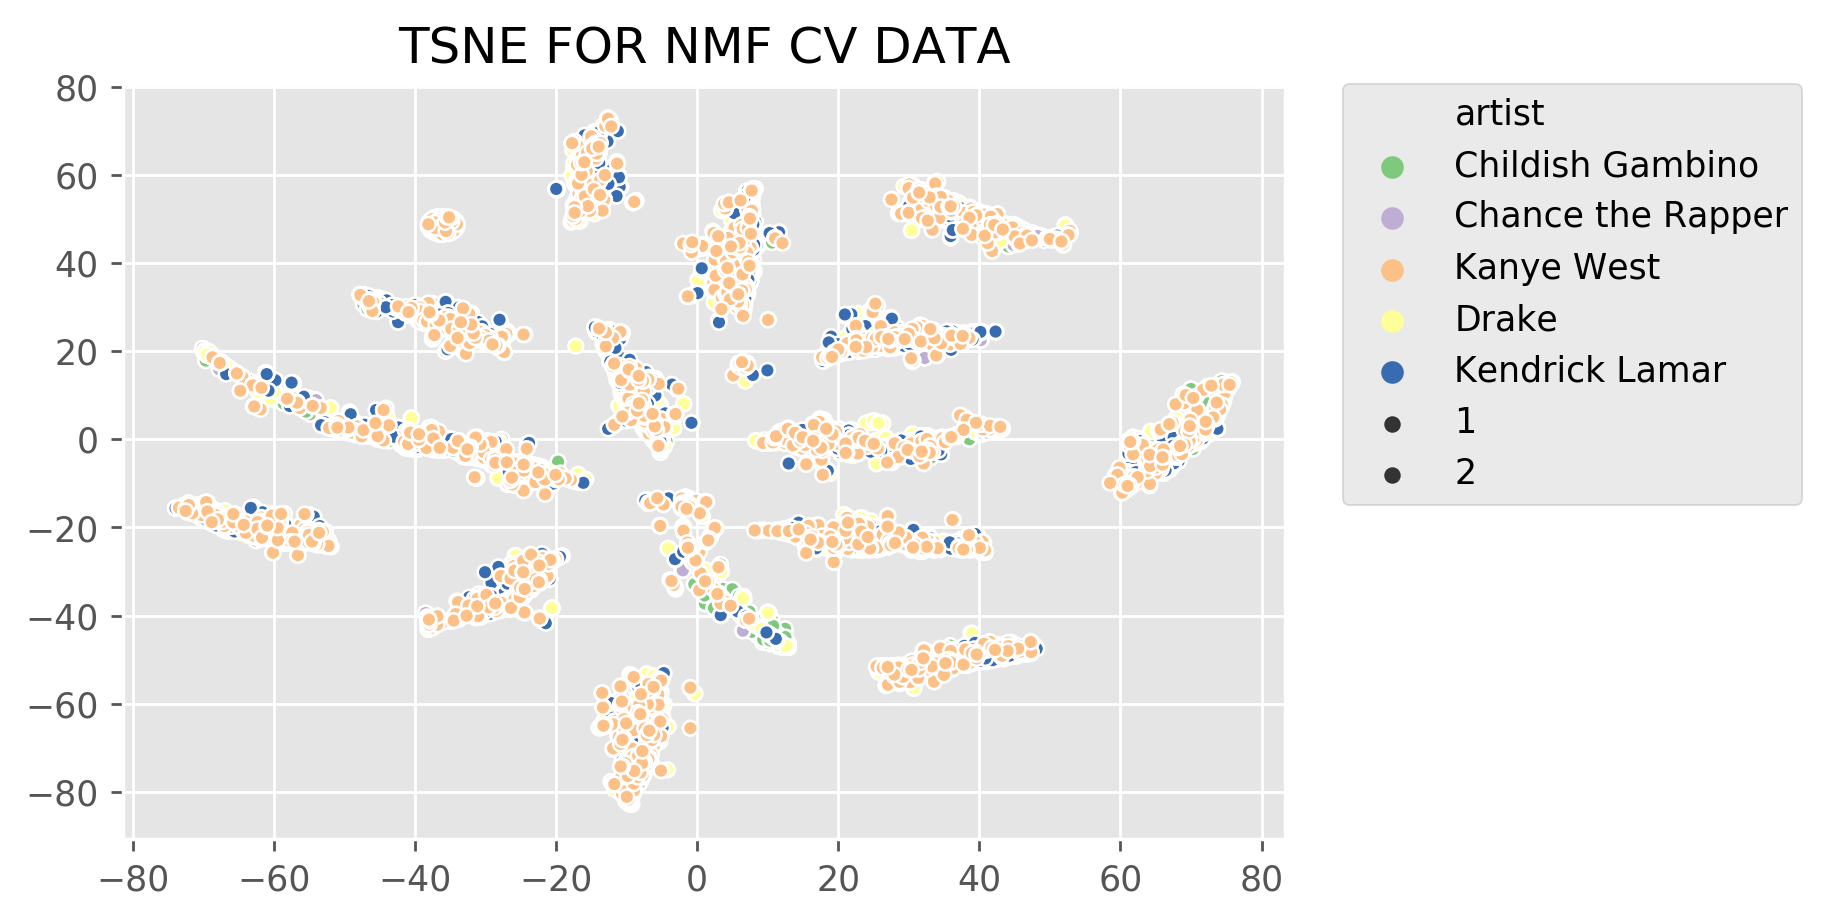

In [127]:
artists = model_df.artist
plt.figure(dpi=250)
plt.title("TSNE FOR NMF CV DATA")
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], artists,
               size = 2, palette = 'Accent', alpha = 'auto',
              markers = '.');

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [42]:
# lsa_cv DIMENSIONALITY REDUCTION ON CV

n_comp = 40
lsa_cv = TruncatedSVD(n_components=n_comp)

lsa_cv_data = lsa_cv.fit_transform(cv_data)

var_cv = lsa_cv.explained_variance_ratio_

var_cv1 = np.cumsum(np.round(lsa_cv.explained_variance_ratio_, decimals=4)*100)

display_topics(lsa_cv,count_vectorizer.get_feature_names(),15)


Topic  0
say, make, ai, love, tell, man, cause, need, time, wan, let, feel, ll, come, think

Topic  1
ring, ring ring, hugh, buzzer, ring buzzer, buzzer hugh, hugh ring, hugh hugh, buzzer ring, chance, chance ring, ring chance, things, guess, yo

Topic  2
love, love love, wan, wan love, love wan, wan wan, ove, ove love, lo ove, love lo, lo, say love, mo, complicate, love say

Topic  3
cam, cam cam, ta, ta cam, cam ta, love, cam lotta, lotta ta, lotta, love love, god, ft, kanye west, kanye, mark

Topic  4
wan, wan wan, mo, mo mo, wan mo, mo wan, wan love, everybody, love wan, mama, wan wa, wa wan, girl, wa, everybody wan

Topic  5
juke, juke juke, break, town, chi, chi town, town break, break chi, break break, juke break, break juke, wan, wan wan, gon, love love

Topic  6
need, need need, wan, right, wan wan, girl, hand, god, juke, juke juke, need right, clap, bad bitch, clap hand, yeezy

Topic  7
man, let, man let, black, need, let man, man man, black man, need need, money, man black,

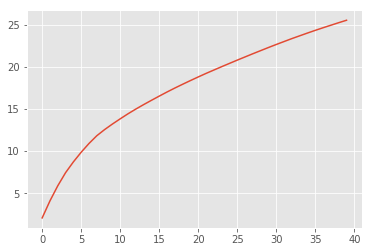

In [43]:
## FIGURE OUT HOW MANY COMPONENTS TO USE

plt.plot(var_cv1)

In [44]:
X_embedded = TSNE(n_components=2, verbose=1, perplexity=50).fit_transform(lsa_cv_data)
X_embedded.shape

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6304 samples in 0.009s...
[t-SNE] Computed neighbors for 6304 samples in 3.006s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6304
[t-SNE] Computed conditional probabilities for sample 2000 / 6304
[t-SNE] Computed conditional probabilities for sample 3000 / 6304
[t-SNE] Computed conditional probabilities for sample 4000 / 6304
[t-SNE] Computed conditional probabilities for sample 5000 / 6304
[t-SNE] Computed conditional probabilities for sample 6000 / 6304
[t-SNE] Computed conditional probabilities for sample 6304 / 6304
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.253815
[t-SNE] Error after 1000 iterations: 1.580138


(6304, 2)

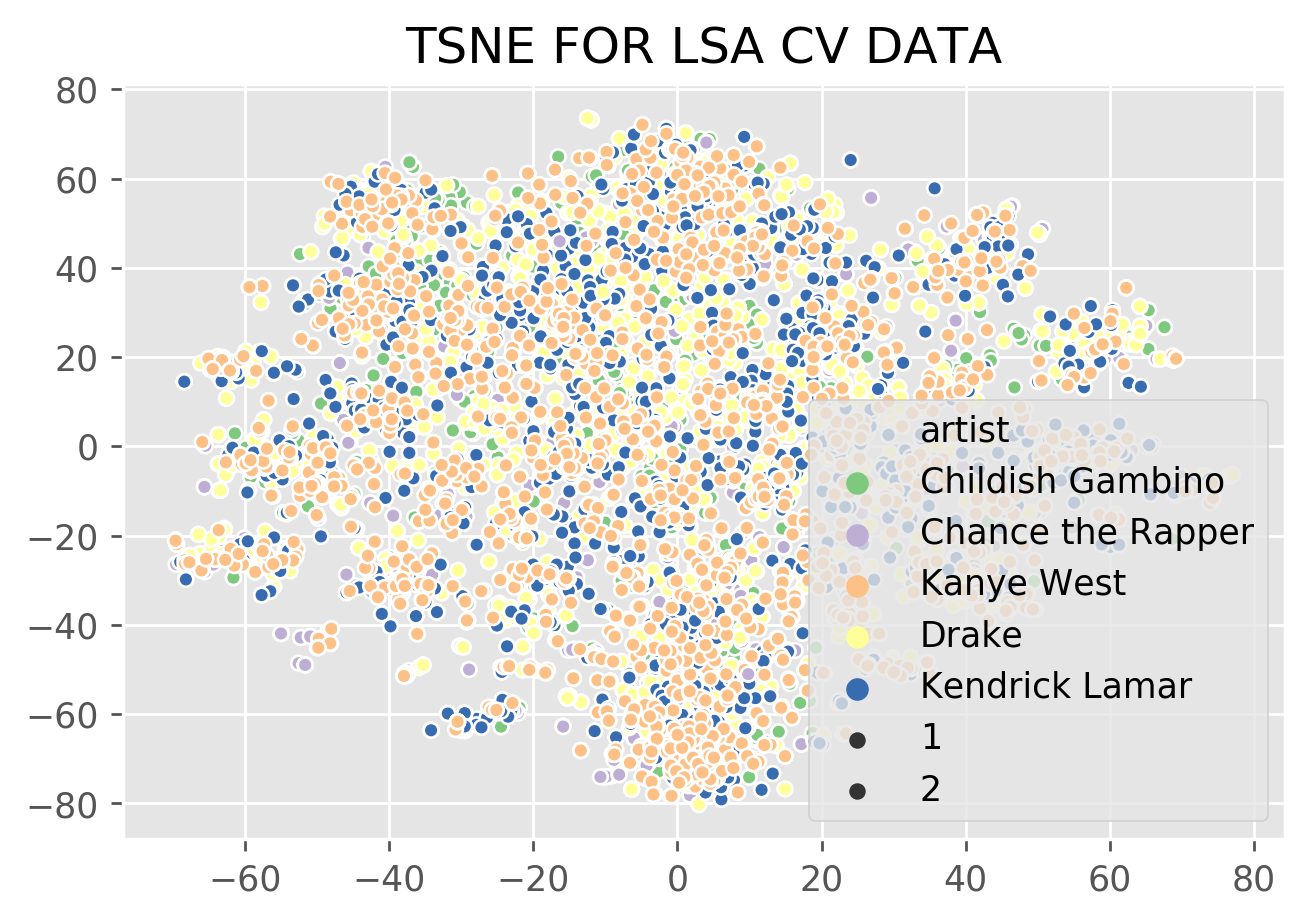

In [45]:
artists = model_df.artist
plt.figure(dpi=250)
plt.title("TSNE FOR LSA CV DATA")
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], artists,
               size = 2, palette = 'Accent', alpha = 'auto',
              markers = '.');

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [46]:
## LDA WITH TFIDF

n_comp = 15
lda_tfidf = LatentDirichletAllocation(n_components=n_comp)

lda_tfidf_data = lda_tfidf.fit_transform(tfidf_data)

# var = lda_tfidf.explained_variance_ratio_

# var1 = np.cumsum(np.round(lda_tfidf.explained_variance_ratio_, decimals=4)*100)

display_topics(lda_tfidf,tfidf_vectorizer.get_feature_names(),15)

/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)



Topic  0
say, love, make, tell, man, right, ai, let, time, feel, wan, cause, ca, ll, come

Topic  1
maine, blaow, aye aye, centipede, centipede centipede, piff, away baby, blaow blaow, cleve, somebody woulda, woulda tell, breathe breathe, girl stop, mona lisa, mona

Topic  2
forever forever, fu, stay wake, party party, snobbery, diamonds forever, panda, wake creepin, ucla, girls ucla, radio hit, album radio, fu fu, fu kenny, kung

Topic  3
bitch grab, glass grab, celebration bitch, grab drink, grab glass, grab yo, dopeness, state facts, wan holla, kinds, notebooks, scribble, holla cut, scribble notebooks, ask entertain

Topic  4
igh, igh igh, lah, nanananana, rakim, lah lah, wish song, stick root, features, music lah, process, man black, fantasize, pierre, kool rap

Topic  5
ayyy, ayyy ayyy, shine throw, throw yo, major major, yo hand, ca speak, oakland, gots shine, terrify, major mon, hide terrify, jacob thou, homie major, mon homie

Topic  6
corrupted, robocop, need god, dammit need

In [47]:
X_embedded = TSNE(n_components=2, verbose=1, perplexity=50).fit_transform(lda_tfidf_data)
X_embedded.shape

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6304 samples in 0.005s...
[t-SNE] Computed neighbors for 6304 samples in 0.418s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6304
[t-SNE] Computed conditional probabilities for sample 2000 / 6304
[t-SNE] Computed conditional probabilities for sample 3000 / 6304
[t-SNE] Computed conditional probabilities for sample 4000 / 6304
[t-SNE] Computed conditional probabilities for sample 5000 / 6304
[t-SNE] Computed conditional probabilities for sample 6000 / 6304
[t-SNE] Computed conditional probabilities for sample 6304 / 6304
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.012531
[t-SNE] Error after 1000 iterations: 0.298968


(6304, 2)

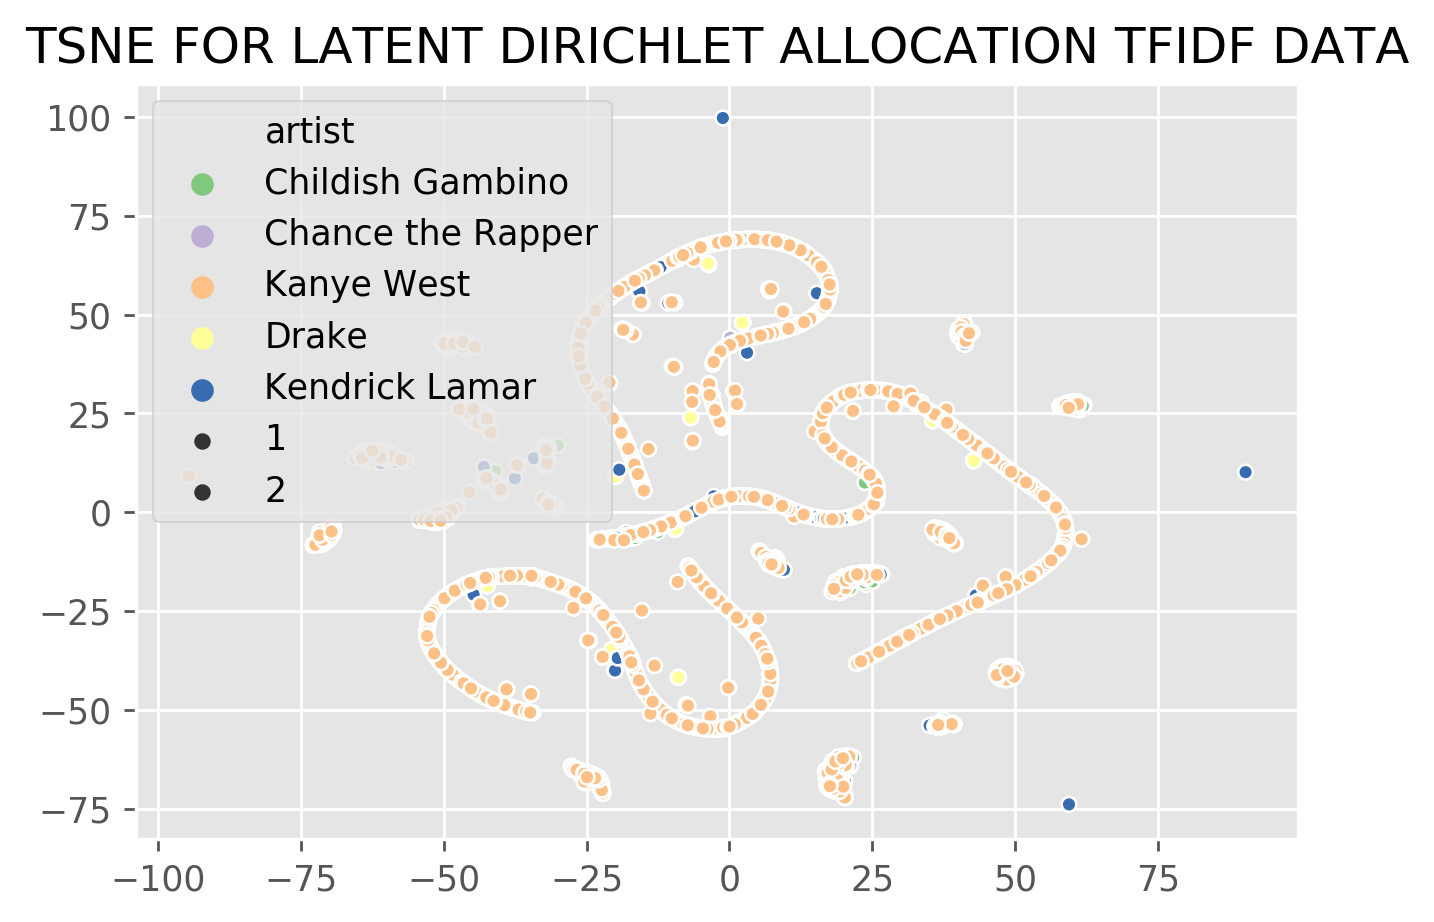

In [48]:
artists = model_df.artist
plt.figure(dpi=250)
plt.title("TSNE FOR LATENT DIRICHLET ALLOCATION TFIDF DATA")
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], artists,
               size = 2, palette = 'Accent', alpha = 'auto',
              markers = '.');

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [119]:
## LDA WITH CV

n_comp = 15
lda_cv = LatentDirichletAllocation(n_components=n_comp)

lda_cv_data = lda_cv.fit_transform(cv_data)

# var = lda_tfidf.explained_variance_ratio_

# var1 = np.cumsum(np.round(lda_tfidf.explained_variance_ratio_, decimals=4)*100)

display_topics(lda_cv,count_vectorizer.get_feature_names(),15)


Topic  0
let, gon, wake, fall, kendrick, brain, let let, cells, brain cells, best best, stand, burn, lamar, kendrick lamar, weather

Topic  1
love, feel, say, good, way, make, better, love love, hold, leave, time, say say, come, ve, ll

Topic  2
need, god, need need, new, highlight, god god, brand, brand new, watch, swear, music, swear god, camera, pool liquor, blue

Topic  3
man, black, kanye, south, money, west, kanye west, black man, yea, shut, somebody, man man, type, sayin, wack

Topic  4
friends friends, ho, forever forever, zoom, weave, ho ho, zoom zoom, ta lie, planet, scratch, sunshine, west, throw diamonds, dream, wrong things

Topic  5
alright, cam, cam cam, light, shoot, motion, stand, drive slow, light light, slow homie, jesus walk, ca study, roll, flame, suit

Topic  6
hol, juke, juke juke, hol hol, smoke, beyonce, controlla, compton, emotional, spin, break break, make right, controlla controlla, butter, lil bitch

Topic  7
jam, boy, bout, problem, rap, dj, cause, compto

In [120]:
X_embedded = TSNE(n_components=2, verbose=1, perplexity=50).fit_transform(lda_cv_data)
X_embedded.shape

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6304 samples in 0.006s...
[t-SNE] Computed neighbors for 6304 samples in 0.998s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6304
[t-SNE] Computed conditional probabilities for sample 2000 / 6304
[t-SNE] Computed conditional probabilities for sample 3000 / 6304
[t-SNE] Computed conditional probabilities for sample 4000 / 6304
[t-SNE] Computed conditional probabilities for sample 5000 / 6304
[t-SNE] Computed conditional probabilities for sample 6000 / 6304
[t-SNE] Computed conditional probabilities for sample 6304 / 6304
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.809414
[t-SNE] Error after 1000 iterations: 0.446166


(6304, 2)

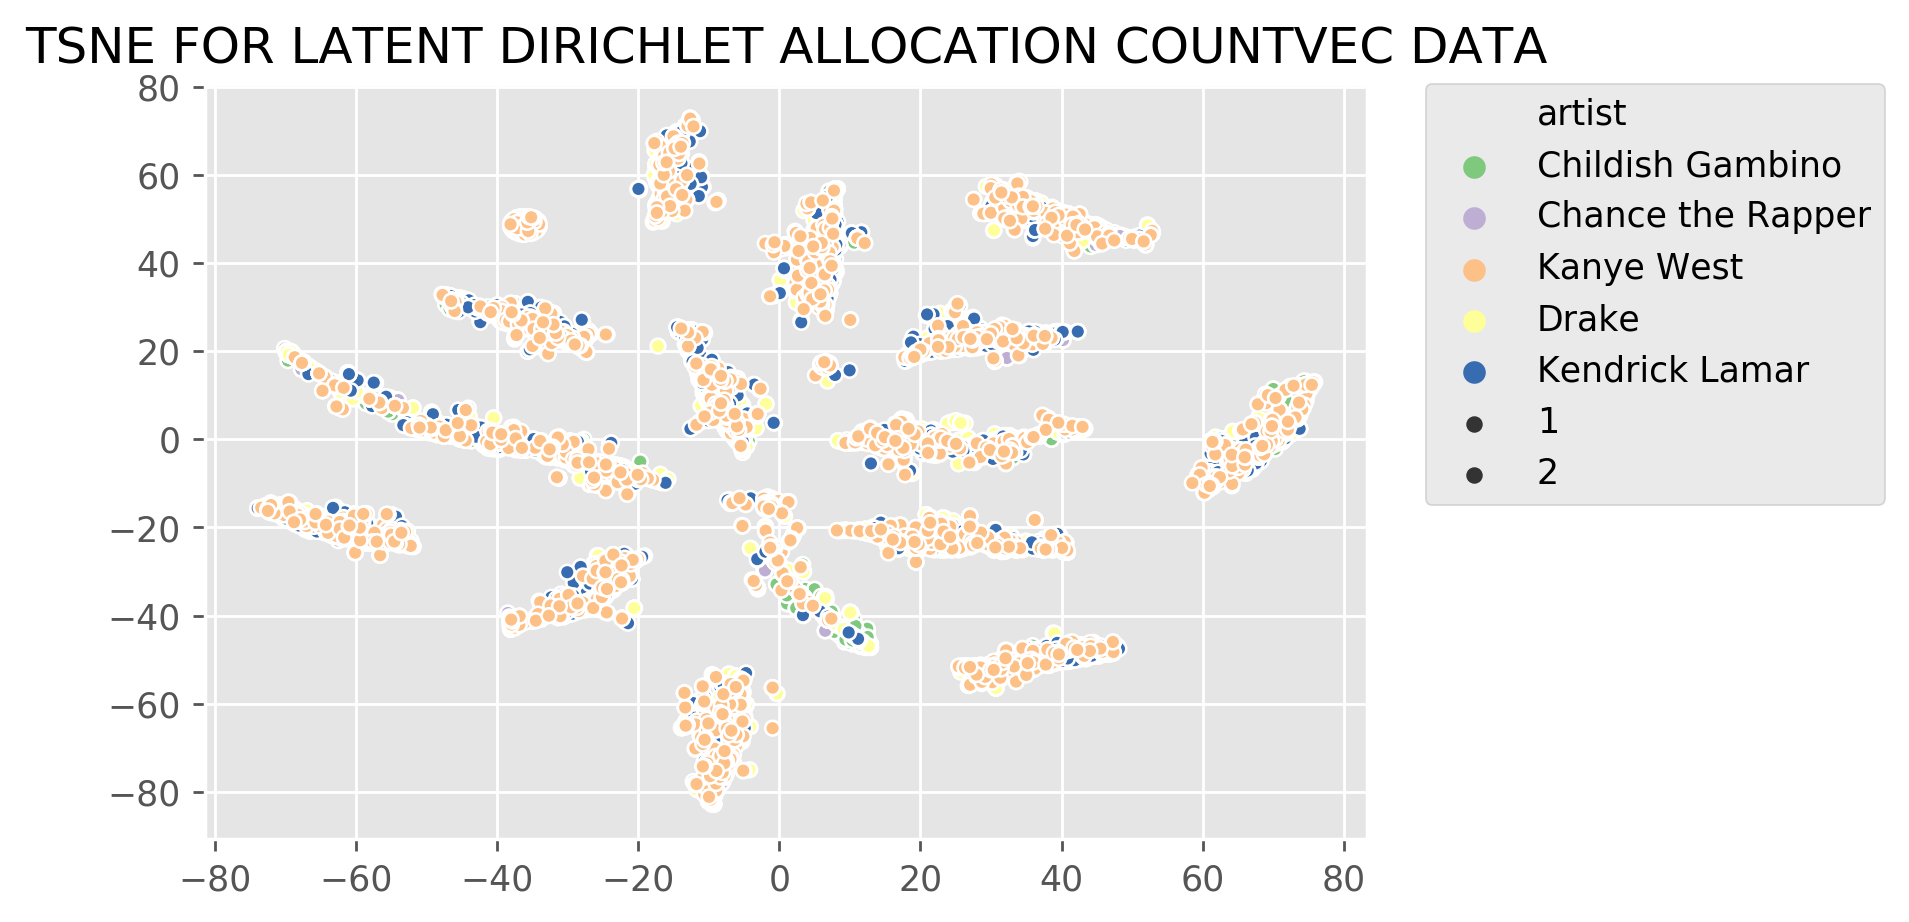

In [128]:
artists = model_df.artist
plt.figure(dpi=250)
plt.title("TSNE FOR LATENT DIRICHLET ALLOCATION COUNTVEC DATA")
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], artists,
               size = 2, palette = 'Accent', alpha = 'auto',
              markers = '.');

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [129]:
## PICKLE LDA ON CV_DATA SO YOU DON'T HAVE TO REFIT IT EACH TIME

with open('models/lda_cv_all_rappers.pkl', 'wb') as picklefile:
    pickle.dump(lda_cv, picklefile)

In [132]:
with open('data/lda_cv_data_all_rappers.pkl', 'wb') as picklefile:
    pickle.dump(lda_cv_data, picklefile)

In [53]:
## PICKLE TRUNCATED SVD ON TFIDF_DATA SO YOU DON'T HAVE TO REFIT IT EACH TIME

# with open('models/lsa_tfidf.pkl', 'wb') as picklefile:
#     pickle.dump(lsa_tfidf, picklefile)

In [54]:
rec_list = get_recommendations(model_df.verse_lem[900], lda_tfidf, tfidf_vectorizer, lda_tfidf_data)
recommendations_correct(900,rec_list)

10.0

In [55]:
percent_corr = []

for i in range(len(model_df)):
    rec_list = get_recommendations(model_df.verse_lem[i], lda_tfidf, tfidf_vectorizer, lda_tfidf_data)
    percent_corr.append(recommendations_correct(i,rec_list))

In [56]:
percent_corr

[50.0,
 40.0,
 20.0,
 60.0,
 50.0,
 50.0,
 60.0,
 90.0,
 0.0,
 50.0,
 30.0,
 30.0,
 50.0,
 40.0,
 50.0,
 10.0,
 40.0,
 0.0,
 50.0,
 0.0,
 0.0,
 10.0,
 10.0,
 0.0,
 10.0,
 10.0,
 30.0,
 40.0,
 30.0,
 10.0,
 30.0,
 0.0,
 10.0,
 10.0,
 10.0,
 0.0,
 30.0,
 20.0,
 0.0,
 0.0,
 20.0,
 10.0,
 70.0,
 50.0,
 20.0,
 50.0,
 0.0,
 50.0,
 10.0,
 20.0,
 20.0,
 20.0,
 0.0,
 20.0,
 0.0,
 10.0,
 10.0,
 30.0,
 0.0,
 20.0,
 20.0,
 50.0,
 40.0,
 90.0,
 40.0,
 90.0,
 30.0,
 80.0,
 70.0,
 20.0,
 0.0,
 20.0,
 10.0,
 10.0,
 50.0,
 10.0,
 20.0,
 20.0,
 10.0,
 10.0,
 0.0,
 0.0,
 20.0,
 10.0,
 20.0,
 0.0,
 20.0,
 10.0,
 0.0,
 0.0,
 60.0,
 0.0,
 10.0,
 10.0,
 0.0,
 20.0,
 0.0,
 20.0,
 0.0,
 20.0,
 10.0,
 30.0,
 50.0,
 20.0,
 0.0,
 20.0,
 40.0,
 10.0,
 20.0,
 30.0,
 70.0,
 60.0,
 30.0,
 70.0,
 70.0,
 20.0,
 30.0,
 40.0,
 10.0,
 0.0,
 20.0,
 20.0,
 50.0,
 50.0,
 50.0,
 10.0,
 50.0,
 30.0,
 70.0,
 50.0,
 80.0,
 20.0,
 20.0,
 0.0,
 60.0,
 50.0,
 10.0,
 10.0,
 50.0,
 30.0,
 10.0,
 20.0,
 20.0,
 0.0,
 30.0,
 20.0,
 10.0

In [57]:
sum(percent_corr)/len(percent_corr)

32.65387055837564

In [58]:
percent_corr = []

for i in range(len(model_df)):
    rec_list = get_recommendations(model_df.verse_lem[i], lsa_tfidf, tfidf_vectorizer, lsa_tfidf_data)
    percent_corr.append(recommendations_correct(i,rec_list))

In [59]:
sum(percent_corr)/len(percent_corr)

41.17703045685279

In [60]:
percent_corr = []

for i in range(len(model_df)):
    rec_list = get_recommendations(model_df.verse_lem[i], lsa_cv, count_vectorizer, lsa_cv_data)
    percent_corr.append(recommendations_correct(i,rec_list))

In [61]:
sum(percent_corr)/len(percent_corr)

35.171319796954315

In [62]:
percent_corr = []

for i in range(len(model_df)):
    rec_list = get_recommendations(model_df.verse_lem[i], nmf_cv, count_vectorizer, nmf_cv_data)
    percent_corr.append(recommendations_correct(i,rec_list))

In [63]:
sum(percent_corr)/len(percent_corr)

34.05298223350254

In [64]:
percent_corr = []

for i in range(len(model_df)):
    rec_list = get_recommendations(model_df.verse_lem[i], lda_cv, count_vectorizer, lda_cv_data)
    percent_corr.append(recommendations_correct(i,rec_list))

In [65]:
sum(percent_corr)/len(percent_corr)

34.0513959390863

USING LSA TFIDF
Percent recommendations with correct artist using 5 components:  31.464149746192895
Percent recommendations with correct artist using 10 components:  32.69670050761421
Percent recommendations with correct artist using 20 components:  35.223667512690355
Percent recommendations with correct artist using 40 components:  38.2630076142132
Percent recommendations with correct artist using 60 components:  40.068210659898476


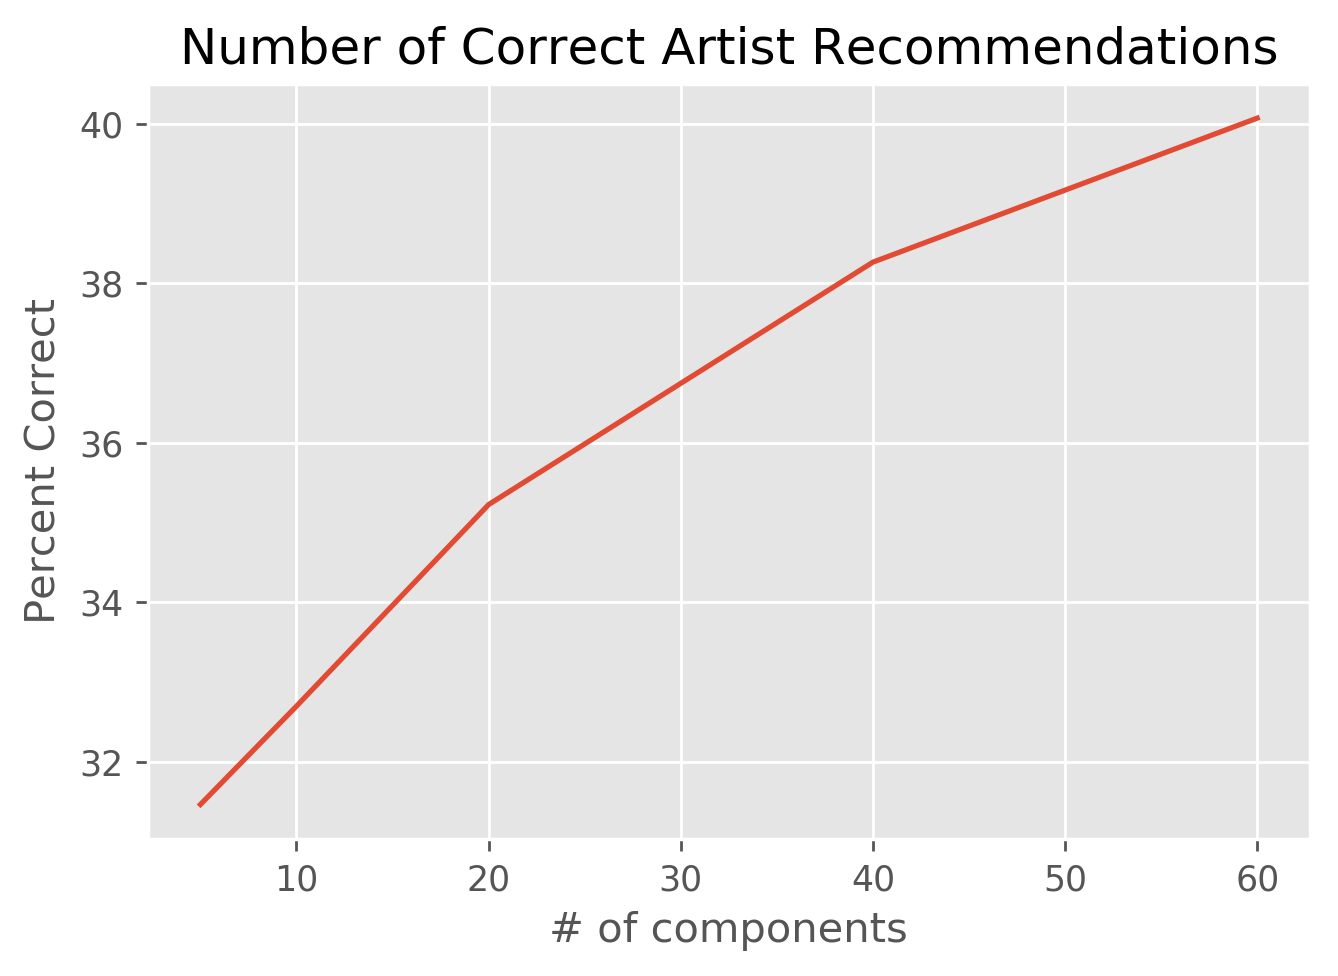

In [66]:
# lsa_tfidf DIMENSIONALITY REDUCTION ON TFIDF

n_comp = [5,10,20,40,60]
print('USING LSA TFIDF')

num_components =[]
perc_corr_per_component = []

for i in n_comp:
    lsa_tfidf = TruncatedSVD(n_components=i)

    lsa_tfidf_data = lsa_tfidf.fit_transform(tfidf_data)

    percent_corr = []

    for j in range(len(model_df)):
        rec_list = get_recommendations(model_df.verse_lem[j], lsa_tfidf, tfidf_vectorizer, lsa_tfidf_data)
        percent_corr.append(recommendations_correct(j,rec_list))
        
    perc_corr_per_component.append((sum(percent_corr)/len(percent_corr)))
    num_components.append(i)
    
    print(f'Percent recommendations with correct artist using {i} components: ',(sum(percent_corr)/len(percent_corr)))
    
plt.figure(dpi=250)
plt.xlabel('# of components')
plt.ylabel('Percent Correct')
plt.title('Number of Correct Artist Recommendations')
plt.plot(num_components, perc_corr_per_component)

USING LSA CV
Percent recommendations with correct artist using 5 components:  30.04758883248731
Percent recommendations with correct artist using 10 components:  32.32709390862944
Percent recommendations with correct artist using 20 components:  34.00856598984772
Percent recommendations with correct artist using 40 components:  34.97937817258883
Percent recommendations with correct artist using 60 components:  36.48953045685279


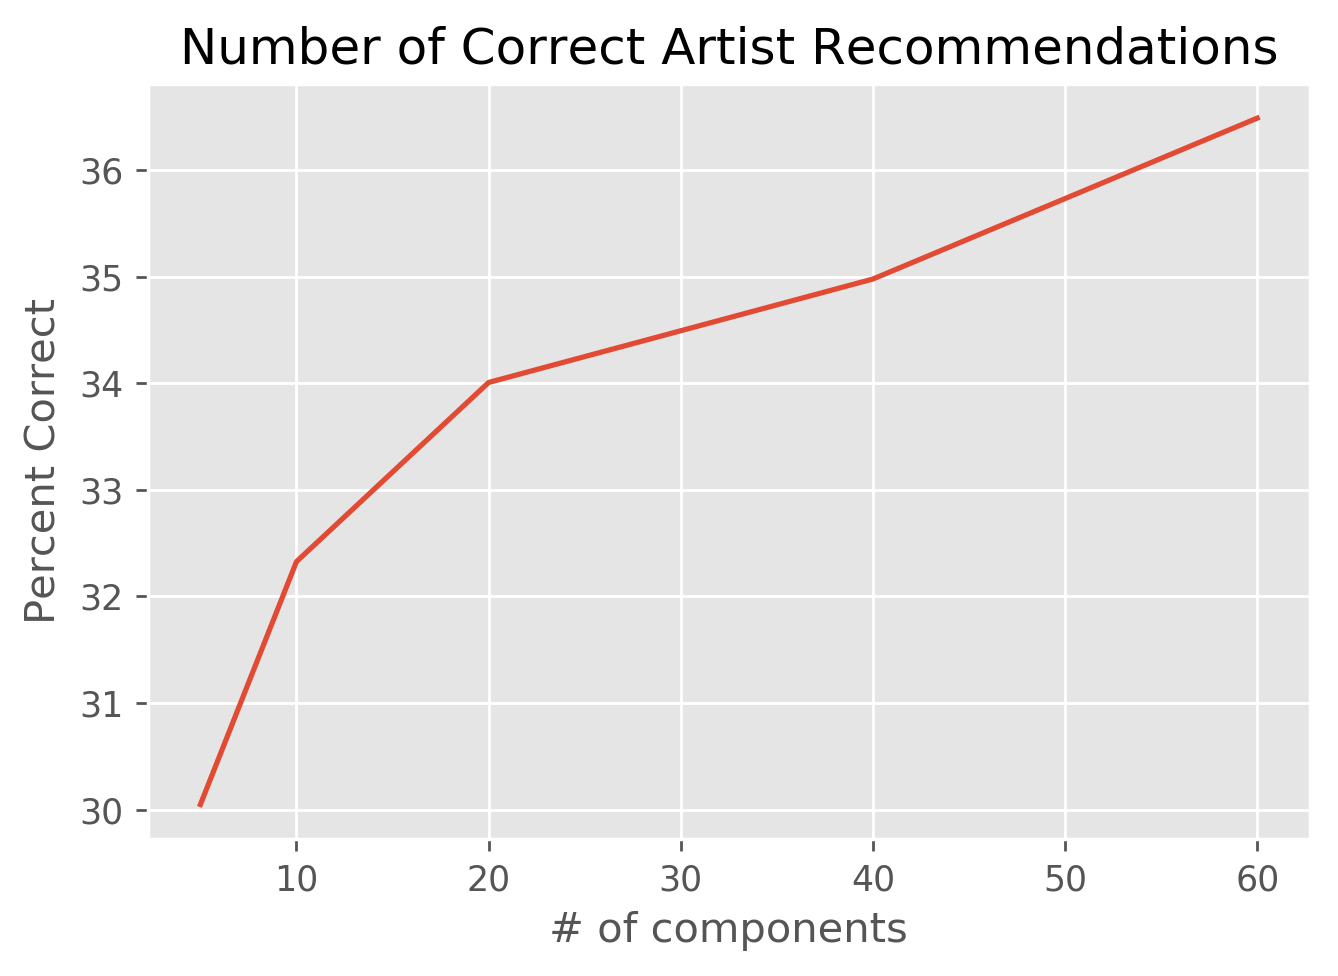

In [67]:
n_comp = [5,10,20,40,60]
print('USING LSA CV')

num_components =[]
perc_corr_per_component = []

for i in n_comp:
    lsa_cv = TruncatedSVD(n_components=i)

    lsa_cv_data = lsa_cv.fit_transform(cv_data)

    percent_corr = []

    for j in range(len(model_df)):
        rec_list = get_recommendations(model_df.verse_lem[j], lsa_cv, count_vectorizer, lsa_cv_data)
        percent_corr.append(recommendations_correct(j,rec_list))
        
    perc_corr_per_component.append((sum(percent_corr)/len(percent_corr)))
    num_components.append(i)
    
    print(f'Percent recommendations with correct artist using {i} components: ',(sum(percent_corr)/len(percent_corr)))
                            
plt.figure(dpi=250)
plt.xlabel('# of components')
plt.ylabel('Percent Correct')
plt.title('Number of Correct Artist Recommendations')
plt.plot(num_components, perc_corr_per_component)

USING NMF CV
Percent recommendations with correct artist using 5 components:  28.251903553299492
Percent recommendations with correct artist using 10 components:  30.302982233502537
Percent recommendations with correct artist using 20 components:  32.6998730964467
Percent recommendations with correct artist using 40 components:  34.17988578680203
Percent recommendations with correct artist using 60 components:  35.75983502538071


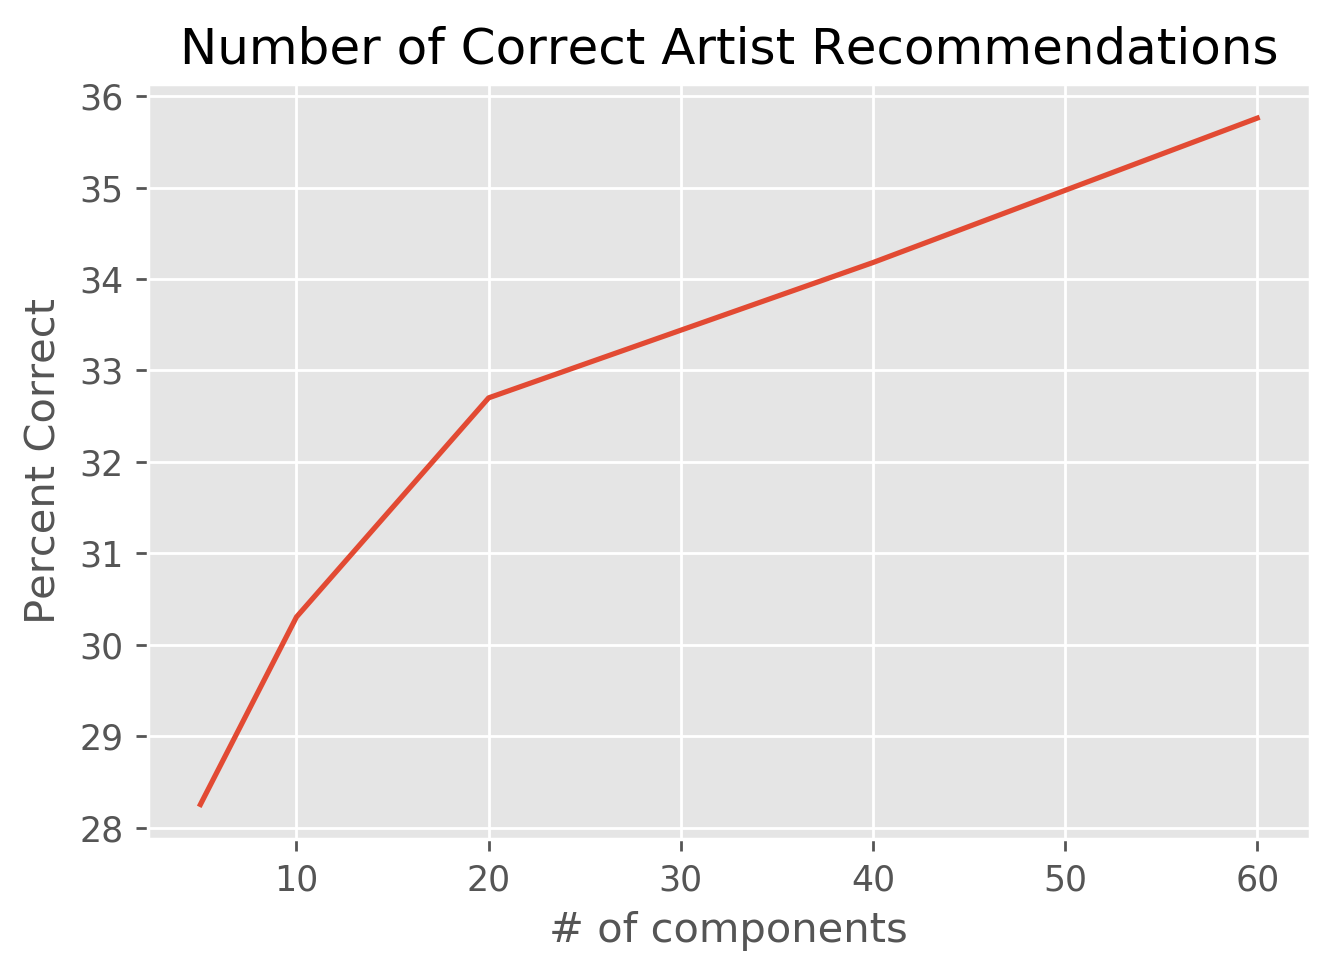

In [68]:
n_comp = [5,10,20,40,60]
print('USING NMF CV')

num_components =[]
perc_corr_per_component = []

for i in n_comp:
    nmf_cv = NMF(n_components=i)

    nmf_cv_data = nmf_cv.fit_transform(cv_data)

    percent_corr = []

    for j in range(len(model_df)):
        rec_list = get_recommendations(model_df.verse_lem[j], nmf_cv, count_vectorizer, nmf_cv_data)
        percent_corr.append(recommendations_correct(j,rec_list))
        
    perc_corr_per_component.append((sum(percent_corr)/len(percent_corr)))
    num_components.append(i)
    
    print(f'Percent recommendations with correct artist using {i} components: ',(sum(percent_corr)/len(percent_corr)))
    
plt.figure(dpi=250)
plt.xlabel('# of components')
plt.ylabel('Percent Correct')
plt.title('Number of Correct Artist Recommendations')
plt.plot(num_components, perc_corr_per_component)

USING LDA CV


/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Percent recommendations with correct artist using 2 components:  28.9752538071066


/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Percent recommendations with correct artist using 5 components:  30.90736040609137


/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Percent recommendations with correct artist using 8 components:  32.25095177664975


/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Percent recommendations with correct artist using 10 components:  33.35501269035533


/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Percent recommendations with correct artist using 12 components:  33.691307106598984


/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Percent recommendations with correct artist using 15 components:  33.42956852791878


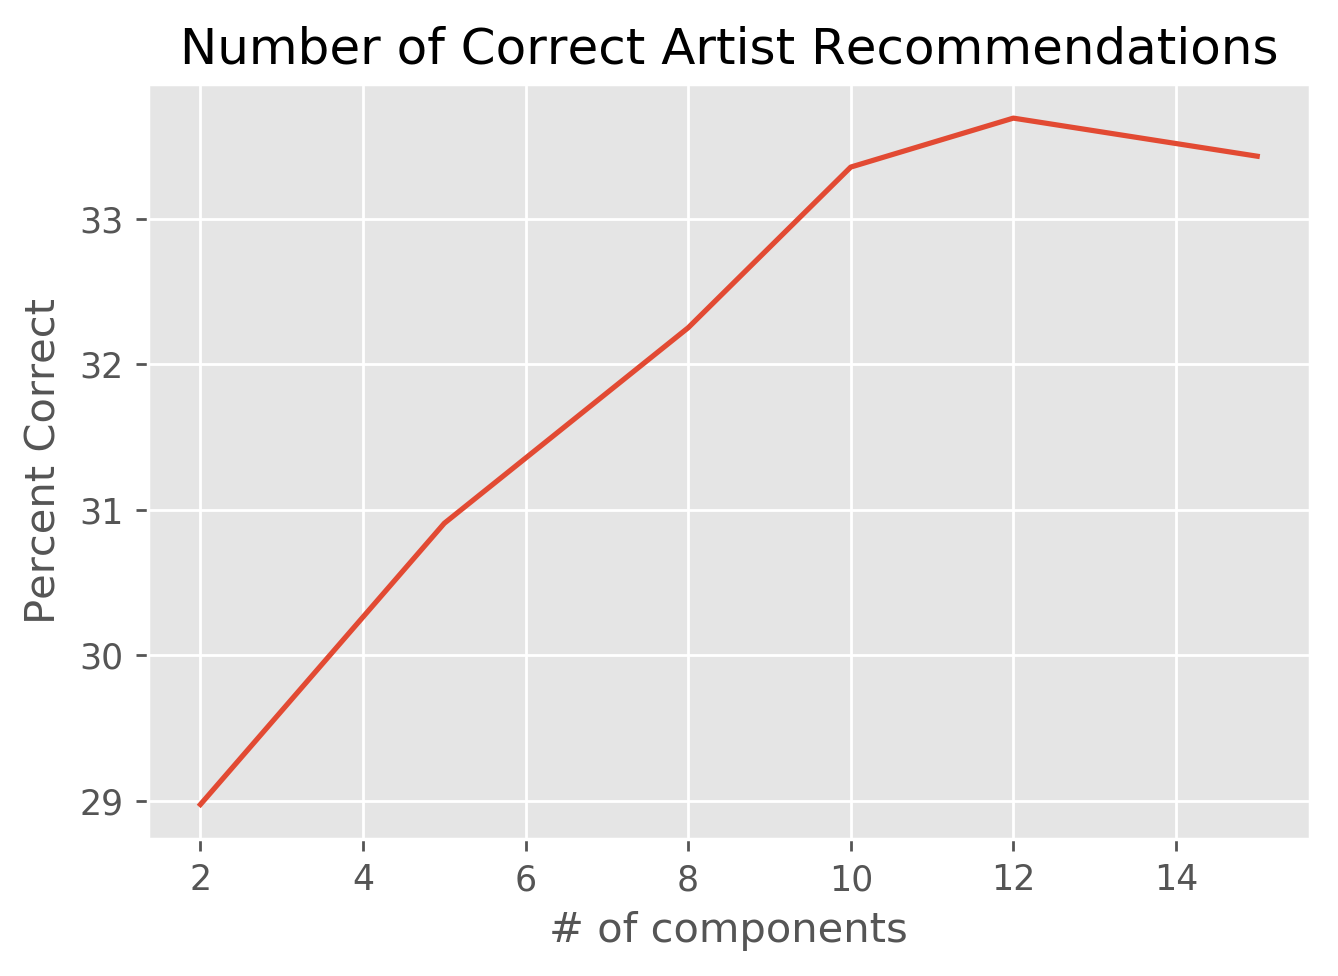

In [69]:
n_comp = [2,5,8,10,12,15]
print('USING LDA CV')

num_components =[]
perc_corr_per_component = []

for i in n_comp:
    lda_cv = LatentDirichletAllocation(n_components=i)

    lda_cv_data = lda_cv.fit_transform(cv_data)

    percent_corr = []

    for j in range(len(model_df)):
        rec_list = get_recommendations(model_df.verse_lem[j], lda_cv, count_vectorizer, lda_cv_data)
        percent_corr.append(recommendations_correct(j,rec_list))
        
    perc_corr_per_component.append((sum(percent_corr)/len(percent_corr)))
    num_components.append(i)
    
    print(f'Percent recommendations with correct artist using {i} components: ',(sum(percent_corr)/len(percent_corr)))
    
plt.figure(dpi=250)
plt.xlabel('# of components')
plt.ylabel('Percent Correct')
plt.title('Number of Correct Artist Recommendations')
plt.plot(num_components, perc_corr_per_component)

USING LDA TFIDF


/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Percent recommendations with correct artist using 2 components:  28.864213197969544


/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Percent recommendations with correct artist using 5 components:  29.294098984771573


/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Percent recommendations with correct artist using 8 components:  30.951776649746193


/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Percent recommendations with correct artist using 10 components:  31.326142131979694


/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Percent recommendations with correct artist using 12 components:  31.365799492385786


/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Percent recommendations with correct artist using 15 components:  31.9876269035533


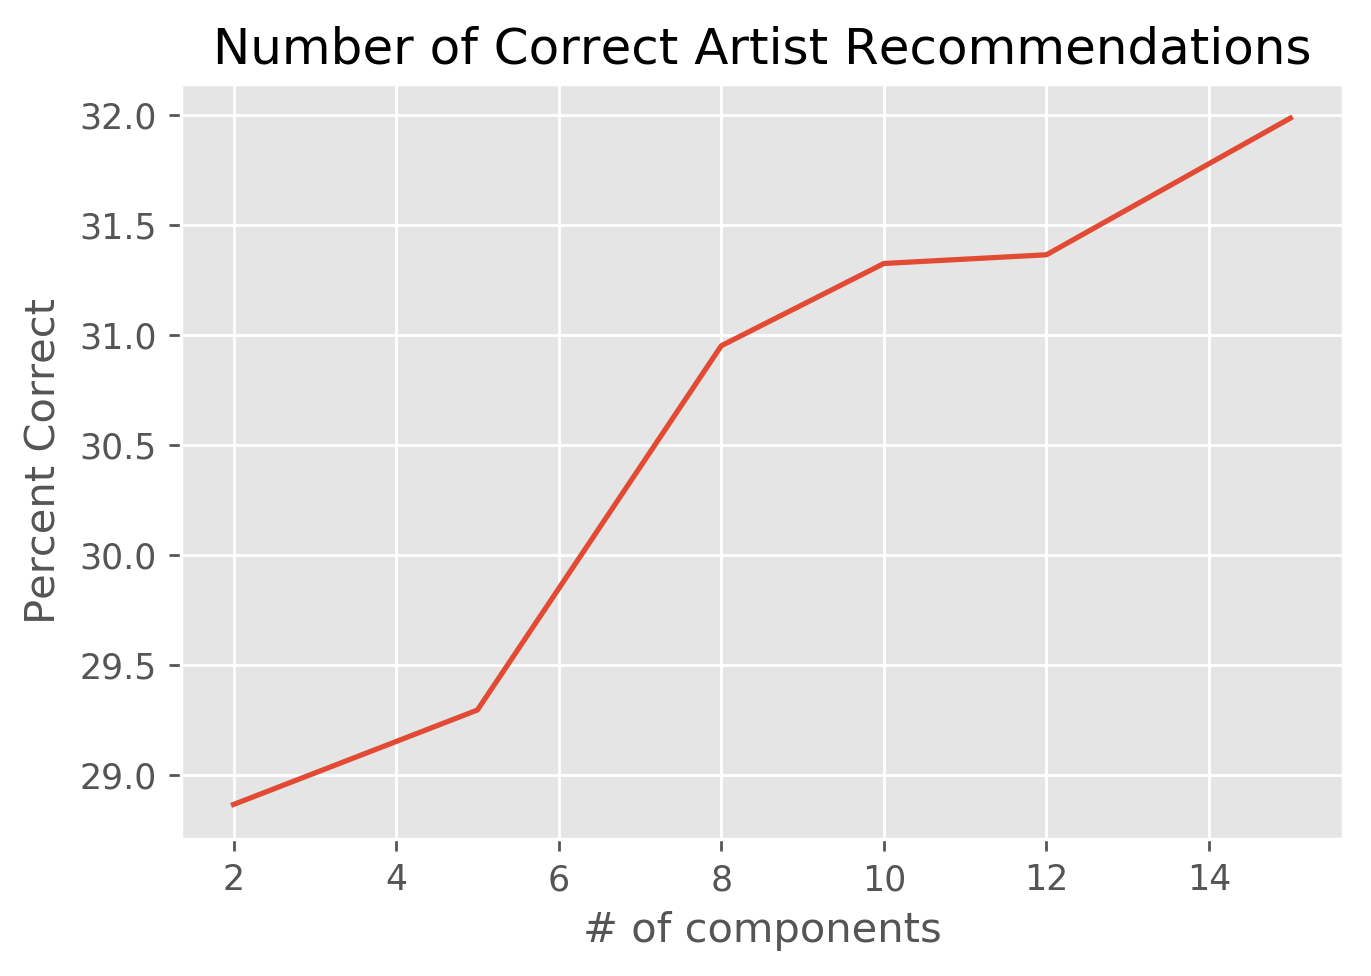

In [70]:
n_comp = [2,5,8,10,12,15]
print('USING LDA TFIDF')

num_components =[]
perc_corr_per_component = []

for i in n_comp:
    lda_tfidf = LatentDirichletAllocation(n_components=i)

    lda_tfidf_data = lda_tfidf.fit_transform(tfidf_data)

    percent_corr = []

    for j in range(len(model_df)):
        rec_list = get_recommendations(model_df.verse_lem[j], lda_tfidf, tfidf_vectorizer, lda_tfidf_data)
        percent_corr.append(recommendations_correct(j,rec_list))
        
    perc_corr_per_component.append((sum(percent_corr)/len(percent_corr)))
    num_components.append(i)
    
    print(f'Percent recommendations with correct artist using {i} components: ',(sum(percent_corr)/len(percent_corr)))
    
plt.figure(dpi=250)
plt.xlabel('# of components')
plt.ylabel('Percent Correct')
plt.title('Number of Correct Artist Recommendations')
plt.plot(num_components, perc_corr_per_component)

Childish Gambino: 1933
Chance: 1596
Proportion: 1.21 : 1
Percentage of Majority Class: 30.659999999999997


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

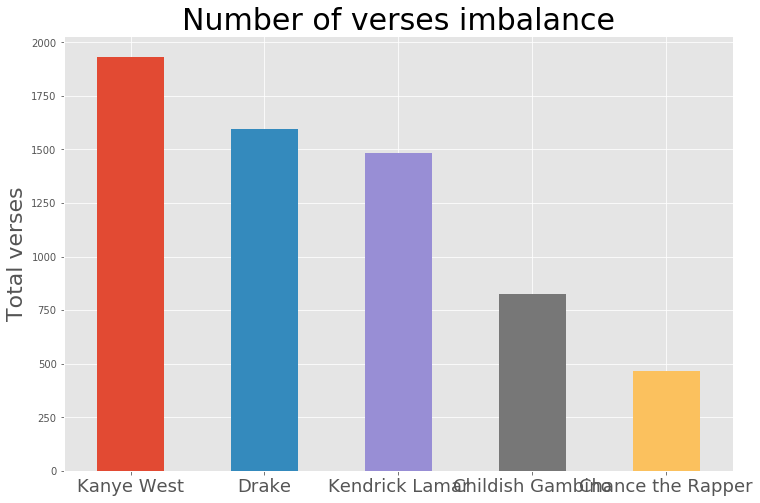

In [71]:
target_count = model_df['artist'].value_counts()
print(f'Childish Gambino: {target_count[0]}')
print(f'Chance: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

target_count.plot(kind='bar', title='Artist Count', rot=0);
plt.gcf().set_size_inches(12,8)
plt.ylabel('Total verses', fontsize=22)
plt.title("Number of verses imbalance", fontsize=30)
plt.xticks(fontsize=18)

In [72]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(model_df, test_size=0.2, random_state=42)

In [73]:
x_train = train_data.verse_lem
y_train = train_data.artist


x_test = test_data.verse_lem
y_test = test_data.artist

In [74]:
print(x_train[:5])

6055    But I don ’ t even wan na hit on you , don ’ t...
2347    Why you over there lookin at me , While your m...
2098    Uhh , yeah , This be really one of my dumbest ...
5673    Homie check it out I get her mesmerize , So wo...
5679    Now the Chocolate Factory be what I bump in my...
Name: verse_lem, dtype: object


In [75]:
print(y_train[:5])

6055    Kanye West
2347         Drake
2098         Drake
5673    Kanye West
5679    Kanye West
Name: artist, dtype: object


In [76]:
#create pipeline
pipe = Pipeline([('tfid', TfidfVectorizer()), ('tfidt', TfidfTransformer()),('nb', MultinomialNB())])
#set param_grid
param_grid = {'tfid__stop_words':[my_stop_words], 'nb__alpha': [0.0001,0.001,0.005,0.1, 0.5, 1, 2]}
#grid search through the parameters 
grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True)
#fit it to my data 
grid.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfid', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...linear_tf=False, use_idf=True)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tfid__stop_words': [frozenset({'into', 'thereby', 'his', 'thru', 'yet', 'those', 'few', 'while', 'as', 'what', 'therein', 'until', 'an', 'made', 'top', 'own', 'but', 'via', 'then', 'nothing', 'wherever', 'itself', 'yeah', 'detail', 'see', 'he', 'these', 'i', 'less', 'elsewhere', 'anothe... 'within', 'hereafter', 'whither', 'nobody'})], 'nb__alpha': [0.0001, 0.001, 0.005, 0.1, 0.5, 1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_tra

In [77]:
grid.best_params_

{'nb__alpha': 0.1,
 'tfid__stop_words': frozenset({'a',
            'about',
            'above',
            'across',
            'after',
            'afterwards',
            'again',
            'against',
            'all',
            'almost',
            'alone',
            'along',
            'already',
            'also',
            'although',
            'always',
            'am',
            'among',
            'amongst',
            'amoungst',
            'amount',
            'an',
            'and',
            'another',
            'any',
            'anyhow',
            'anyone',
            'anything',
            'anyway',
            'anywhere',
            'are',
            'around',
            'as',
            'at',
            'aw',
            'ay',
            'ayy',
            'ba',
            'back',
            'be',
            'became',
            'because',
            'become',
            'becomes',
            'becoming',
            'b

In [78]:
grid_score = cross_val_score(grid, x_train, y_train, cv=5).mean()
y_train_pred = grid.predict(x_train)
grid_score

0.7081092398493707

In [79]:
y_test_pred = grid.predict(x_test)
y_test_pred

array(['Drake', 'Childish Gambino', 'Drake', ..., 'Kanye West',
       'Kanye West', 'Kanye West'], dtype='<U17')

In [80]:
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

0.9069998017053341
0.7272006344171292


In [88]:
models = [LogisticRegression(), KNeighborsClassifier(), SVC(),
           DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), DummyClassifier()]
names = ['LR', 'KNN', 'SVC', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees', 'Dummy']

for i in range(len(models)):
    
    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    
    for train_index, test_index in kf.split(x_train):
        
        kX_train = x_train.iloc[train_index]
        kX_test = x_train.iloc[test_index]
        ky_train = y_train.iloc[train_index]
        ky_test = y_train.iloc[test_index]
        
        model = Pipeline([('tfid', TfidfVectorizer()), ('LSA', TruncatedSVD()), (names[i], models[i])])
        #fit it to my data 
        model.fit(kX_train, ky_train)
        y_train_pred = model.predict(kX_train)

        accuracy.append(accuracy_score(ky_train, y_train_pred))
        precision.append(precision_score(ky_train, y_train_pred, average=None))
        recall.append(recall_score(ky_train, y_train_pred, average=None))
        f1.append(f1_score(ky_train, y_train_pred, average=None))

    model_score = cross_val_score(model, kX_train, ky_train, cv=5).mean()
    
    model_score = np.round(model_score, 4)
    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    
    print('Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION')
    print(f'{names[i]} model_score: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
    print('')

Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION
LR model_score: 0.3477 accuracy: 0.346 precision: 0.1565 recall: 0.2413 f1: 0.1779

Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION
KNN model_score: 0.3391 accuracy: 0.5561 precision: 0.5317 recall: 0.5247 f1: 0.525

Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION
SVC model_score: 0.3558 accuracy: 0.3546 precision: 0.1533 recall: 0.2441 f1: 0.1766

Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION
Decision Tree model_score: 0.3968 accuracy: 0.9966 precision: 0.9975 recall: 0.9957 f1: 0.9966

Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION
Random Forest model_score: 0.409 accuracy: 0.9742 precision: 0.9752 recall: 0.9731 f1: 0.9741

Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION
Gradient Boosted Trees model_score: 0.3894 accuracy: 0.5293 precision: 0.6957 recall: 0.4463 f1: 0.4726

Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION
Dummy model_score: 0.2341 accuracy: 

In [92]:
models = [('tree', DecisionTreeClassifier)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LSA', TruncatedSVD()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LSA__n_components': [20,40,60],
                  'tree__max_depth': [1,2,3,4,5,6,7], 'tree__min_samples_leaf': [3,6,8,10,12,15]}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

tree: best score: 0.3942097957564942, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])


In [93]:
dt1 = grid.best_estimator_
dt1.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [94]:
model = dt1

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
    
for train_index, test_index in kf.split(x_train):

    kX_train = x_train.iloc[train_index]
    kX_test = x_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    y_predict = model.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, average=None))
    recall.append(recall_score(ky_test, y_predict, average=None))
    f1.append(f1_score(ky_test, y_predict, average=None))

model_score = cross_val_score(model, kX_train, ky_train, cv=5).mean()    

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
model_score = np.round(model_score, 4)

print('DECISION TREE MVP')
print(f'modelscore: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
print('')

DECISION TREE MVP
modelscore: 0.382 accuracy: 0.5134 precision: 0.509 recall: 0.4175 f1: 0.4256



In [95]:
models = [('LogReg', LogisticRegression)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LSA', TruncatedSVD()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LSA__n_components': [20,40,60], 'LogReg__C': np.logspace(-3,6, 12)}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

LogReg: best score: 0.4606385088241126, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])


In [96]:
lm1 = grid.best_estimator_
lm1.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [97]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
    
for train_index, test_index in kf.split(x_train):

    kX_train = x_train.iloc[train_index]
    kX_test = x_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    y_predict = lm1.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, average=None))
    recall.append(recall_score(ky_test, y_predict, average=None))
    f1.append(f1_score(ky_test, y_predict, average=None))

model_score = cross_val_score(lm1, kX_train, ky_train, cv=5).mean()    

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
model_score = np.round(model_score, 4)

print('Logistic Regress MVP')
print(f'modelscore: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
print('')

Logistic Regress MVP
modelscore: 0.4554 accuracy: 0.4789 precision: 0.5036 recall: 0.3901 f1: 0.3966



In [98]:
models = [('forest', RandomForestClassifier)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LSA', TruncatedSVD()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LSA__n_components': [20,40,60],
                  'forest__n_estimators': [25,50, 100, 200], 'forest__max_depth': [1,2,3,4,5,7,10],
                  'forest__min_samples_leaf': [3,6,10]}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

forest: best score: 0.5574063057703748, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


In [99]:
rf1 = grid.best_estimator_
rf1.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [100]:
model = rf1

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
    
for train_index, test_index in kf.split(x_train):

    kX_train = x_train.iloc[train_index]
    kX_test = x_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    y_predict = model.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, average=None))
    recall.append(recall_score(ky_test, y_predict, average=None))
    f1.append(f1_score(ky_test, y_predict, average=None))

model_score = cross_val_score(model, kX_train, ky_train, cv=5).mean()    

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
model_score = np.round(model_score, 4)

print('RANDOM FOREST ALL RAPPERS')
print(f'modelscore: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
print('')

RANDOM FOREST ALL RAPPERS
modelscore: 0.5309 accuracy: 0.8255 precision: 0.8946 recall: 0.7128 f1: 0.745



In [101]:
models = [('knn', KNeighborsClassifier)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LSA', TruncatedSVD()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LSA__n_components': [20,40,60],
                  'knn__n_neighbors': range(1, 12)}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

knn: best score: 0.5385683125123935, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...owski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])


In [102]:
knn1 = grid.best_estimator_
knn1.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...owski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])

In [103]:
model = knn1

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
    
for train_index, test_index in kf.split(x_train):

    kX_train = x_train.iloc[train_index]
    kX_test = x_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    y_predict = model.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, average=None))
    recall.append(recall_score(ky_test, y_predict, average=None))
    f1.append(f1_score(ky_test, y_predict, average=None))

model_score = cross_val_score(model, kX_train, ky_train, cv=5).mean()    

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
model_score = np.round(model_score, 4)

print('K-NEAREST NEIGHBORS ALL RAPPERS')
print(f'modelscore: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
print('')

K-NEAREST NEIGHBORS ALL RAPPERS
modelscore: 0.5125 accuracy: 0.9867 precision: 0.9906 recall: 0.9837 f1: 0.9871



In [ ]:
from sklearn.metrics import confusion_matrix

model = lm1

predict_y_train = model.predict(x_train)

LR_cross_val = cross_val_score(model, x_train, y_train, scoring='accuracy', cv = 10)
print('The mean of 10 fold cross validation accuracy score on LogReg model is', str(round(np.mean(LR_cross_val), 3)))

LR = confusion_matrix(y_train, predict_y_train)
LR_CM = print_confusion_matrix(LR, ['Chance The Rapper', 'Childish Gambino'])

In [ ]:
from sklearn.metrics import confusion_matrix

model = rf1

predict_y_train = model.predict(x_train)

RF_cross_val = cross_val_score(model, x_train, y_train, scoring='accuracy', cv = 10)
print('The mean of 10 fold cross validation accuracy score on Random Forest model is', str(round(np.mean(RF_cross_val), 3)))

RF = confusion_matrix(y_train, predict_y_train)
RF_CM = print_confusion_matrix(RF, ['Chance The Rapper', 'Childish Gambino'])

In [ ]:
from sklearn.metrics import confusion_matrix

model = knn1

predict_y_train = model.predict(x_train)

KNN_cross_val = cross_val_score(model, x_train, y_train, scoring='accuracy', cv = 10)
print('The mean of 10 fold cross validation accuracy score on KNN model is', str(round(np.mean(KNN_cross_val), 3)))

KNN = confusion_matrix(y_train, predict_y_train)
KNN_CM = print_confusion_matrix(KNN, ['Chance The Rapper', 'Childish Gambino'])

In [104]:
models = [('dc', DummyClassifier)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LSA', TruncatedSVD()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LSA__n_components': [20,40,60]}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

dc: best score: 0.23775530438231213, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...e=None, tol=0.0)), ('dc', DummyClassifier(constant=None, random_state=None, strategy='stratified'))])


In [105]:
dc = grid.best_estimator_
dc.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...e=None, tol=0.0)), ('dc', DummyClassifier(constant=None, random_state=None, strategy='stratified'))])

In [106]:
models = [('knn', KNeighborsClassifier)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LSA', TruncatedSVD()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LSA__n_components': [20,40,60]}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

knn: best score: 0.4340670235970652, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])


In [107]:
knn2 = grid.best_estimator_
knn2.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])

In [108]:
models = [('RF', RandomForestClassifier)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LSA', TruncatedSVD()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LSA__n_components': [20,40,60]}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

RF: best score: 0.5336109458655562, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


In [109]:
rf2 = grid.best_estimator_
rf2.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [110]:
model = rf2

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
    
for train_index, test_index in kf.split(x_train):

    kX_train = x_train.iloc[train_index]
    kX_test = x_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    y_predict = model.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, average=None))
    recall.append(recall_score(ky_test, y_predict, average=None))
    f1.append(f1_score(ky_test, y_predict, average=None))

model_score = cross_val_score(model, kX_train, ky_train, cv=5).mean()    

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
model_score = np.round(model_score, 4)

print('RANDOM FOREST NO TUNING ALL RAPPERS')
print(f'modelscore: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
print('')

RANDOM FOREST NO TUNING ALL RAPPERS
modelscore: 0.5086 accuracy: 0.9822 precision: 0.9852 recall: 0.9798 f1: 0.9824



In [111]:
models = [('tree', DecisionTreeClassifier)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LSA', TruncatedSVD()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LSA__n_components': [20,40,60]}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

tree: best score: 0.4854253420582986, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])


In [112]:
dt2 = grid.best_estimator_
dt2.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [113]:
model = dt2

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
    
for train_index, test_index in kf.split(x_train):

    kX_train = x_train.iloc[train_index]
    kX_test = x_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    y_predict = model.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, average=None))
    recall.append(recall_score(ky_test, y_predict, average=None))
    f1.append(f1_score(ky_test, y_predict, average=None))

model_score = cross_val_score(model, kX_train, ky_train, cv=5).mean()    

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
model_score = np.round(model_score, 4)

print('Decision Tree NO TUNING ALL RAPPERS')
print(f'modelscore: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
print('')

Decision Tree NO TUNING ALL RAPPERS
modelscore: 0.4551 accuracy: 0.9877 precision: 0.9906 recall: 0.9853 f1: 0.9878



In [114]:
models = [lm1, rf1, knn1, dc, knn2, dt1, rf2, dt2]
names = ['LogReg', 'Random Forest', 'KNN', 'Dummy', 'KNN2', 'Decision Tree', 'RF2', 'DT2']

print(f'TEST Scores ALL RAPPERS')

for model, name in zip(models, names):

    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []

    y_predict = model.predict(x_test)

    accuracy.append(accuracy_score(y_test, y_predict))
    precision.append(precision_score(y_test, y_predict, average=None))
    recall.append(recall_score(y_test, y_predict, average=None))
    f1.append(f1_score(y_test, y_predict, average=None))

    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)


    print(f'{name} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
    print('')

TEST Scores ALL RAPPERS
LogReg accuracy: 0.4711 precision: 0.5066 recall: 0.39 f1: 0.3975

Random Forest accuracy: 0.5583 precision: 0.7038 recall: 0.4615 f1: 0.472

KNN accuracy: 0.5749 precision: 0.5527 recall: 0.5507 f1: 0.5504

Dummy accuracy: 0.2474 precision: 0.2249 recall: 0.2225 f1: 0.2232

KNN2 accuracy: 0.4671 precision: 0.4379 recall: 0.4442 f1: 0.4387

Decision Tree accuracy: 0.3925 precision: 0.333 recall: 0.3097 f1: 0.3016

RF2 accuracy: 0.5615 precision: 0.5702 recall: 0.5204 f1: 0.5362

DT2 accuracy: 0.525 precision: 0.5066 recall: 0.4983 f1: 0.5013



In [116]:
models = [lm1, rf2, knn2, dt2, dc]
names = ['LogReg', 'Random Forest', 'KNN', 'Decision Tree', 'Dummy']

roc_plotting_stuff = []
for model, name in zip(models, names):
    model.fit(x_train, y_train)
    preds = model.predict_proba(x_test)
    fpr, tpr, _ = roc_curve(y_test, preds[:,1], pos_label = 'Childish Gambino')
    auc_score = auc(fpr, tpr)
    roc_plotting_stuff.append((name, tpr, fpr, auc_score))
    
print(preds)

[[0 0 0 0 1]
 [0 0 1 0 0]
 [0 0 0 0 1]
 ...
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]]


Text(0.5,1,'Comparing ROC Curves')

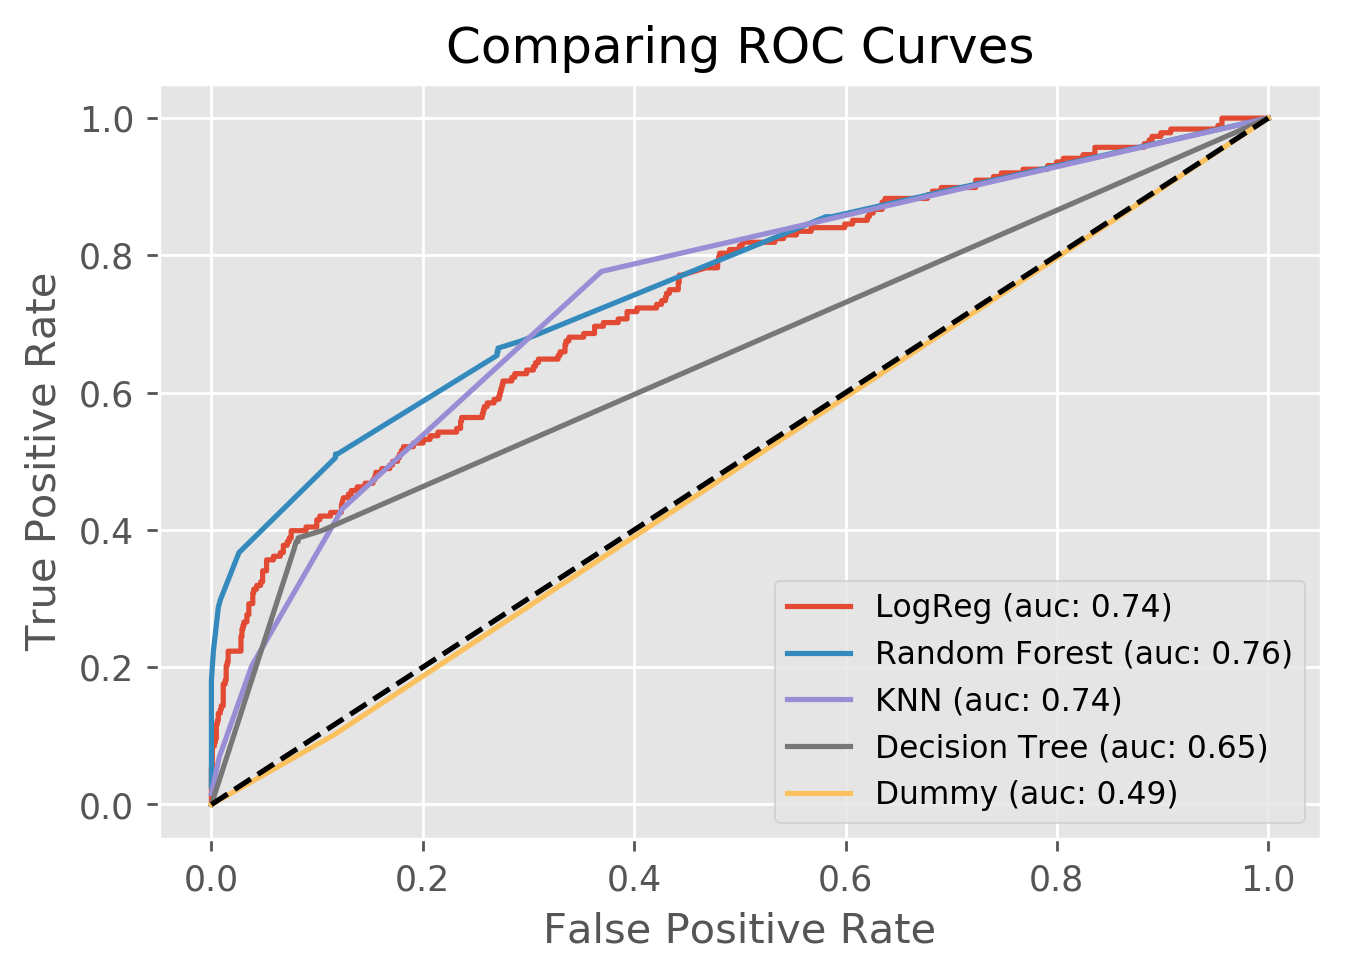

In [117]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.2f)'%auc_score)
plt.legend(loc='lower right', fontsize=9)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves")

In [ ]:
model = rf1

predict_y_test = model.predict(x_test)

LR_cross_val = cross_val_score(model, x_test, y_test, scoring='accuracy', cv = 10)
print('The mean of 10 fold cross validation accuracy score on RF1 model is', str(round(np.mean(LR_cross_val), 3)))

LR = confusion_matrix(y_test, predict_y_test)
LR_CM = print_confusion_matrix(LR, ['Chance The Rapper', 'Childish Gambino'])

In [ ]:
model = rf2

predict_y_test = model.predict(x_test)

LR_cross_val = cross_val_score(model, x_test, y_test, scoring='accuracy', cv = 10)
print('The mean of 10 fold cross validation accuracy score on Random Forest2 model is', str(round(np.mean(LR_cross_val), 3)))

LR = confusion_matrix(y_test, predict_y_test)
LR_CM = print_confusion_matrix(LR, ['Chance The Rapper', 'Childish Gambino'])

In [ ]:
model = dt2

predict_y_test = model.predict(x_test)

LR_cross_val = cross_val_score(model, x_test, y_test, scoring='accuracy', cv = 10)
print('The mean of 10 fold cross validation accuracy score on DecisionTree 2 model is', str(round(np.mean(LR_cross_val), 3)))

LR = confusion_matrix(y_test, predict_y_test)
LR_CM = print_confusion_matrix(LR, ['Chance The Rapper', 'Childish Gambino'])

In [ ]:
model = dc

predict_y_test = model.predict(x_test)

LR_cross_val = cross_val_score(model, x_test, y_test, scoring='accuracy', cv = 10)
print('The mean of 10 fold cross validation accuracy score on Dummy model is', str(round(np.mean(LR_cross_val), 3)))

LR = confusion_matrix(y_test, predict_y_test)
LR_CM = print_confusion_matrix(LR, ['Chance The Rapper', 'Childish Gambino'])

In [ ]:
with open('allartists_RF.pkl', 'wb') as picklefile:
    pickle.dump(rf2, picklefile)
    
with open('allartists_LogReg.pkl', 'wb') as picklefile:
    pickle.dump(lm1, picklefile)
    
with open('allartists_KNN.pkl', 'wb') as picklefile:
    pickle.dump(knn2, picklefile)
    
with open('allartists_DecTree.pkl', 'wb') as picklefile:
    pickle.dump(dt2, picklefile)
    
with open('allartists_Dummy.pkl', 'wb') as picklefile:
    pickle.dump(dc, picklefile)